In [1]:
import numpy as np
import math
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle
from copy import deepcopy
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from scipy.linalg import sqrtm


In [2]:
def compute_fid(real_images, generated_images):
    # Calculate mean and covariance statistics
    mu1, sigma1 = get_mean_and_cov(real_images)
    mu2, sigma2 = get_mean_and_cov(generated_images)

    # Calculate FID
    fid_value = np.sum((mu1 - mu2) ** 2) + np.trace(sigma1 + sigma2 - 2 * sqrtm(sigma1 @ sigma2))
    return fid_value

def get_mean_and_cov(images):
    # Flatten the images and calculate the mean and covariance
    images = images.view(images.size(0), -1).cpu().detach().numpy()
    mu = np.mean(images, axis=0)
    sigma = np.cov(images, rowvar=False)
    return mu, sigma

def calculate_snr(original, reconstructed):
    snr = 10 * torch.log10(torch.mean(original ** 2) / torch.mean((original - reconstructed) ** 2))
    return snr.item()

def plot_metrics(vae_losses, diffusion_losses, snr_values, fid_values):
    plt.figure(figsize=(12, 8))

    # Plot losses
    plt.subplot(2, 1, 1)
    plt.plot(vae_losses, label='VAE Loss')
    plt.plot(diffusion_losses, label='Diffusion Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot SNR and FID
    plt.subplot(2, 1, 2)
    plt.plot(snr_values, label='SNR')
    plt.plot(fid_values, label='FID')
    plt.title('SNR and FID')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [3]:
def visualize_reconstruction(model, diffusion, vae, images, epoch, TT_trunc):
    model.eval()
    vae.eval()
    with torch.no_grad():


        t_trunc = torch.full((images.shape[0],), TT_trunc, device=images.device)
        noisy_images_trunc, _ = diffusion.forward_diffusion(images, t_trunc)

        recon_y, _, _, _ = vae(noisy_images_trunc)

        # Reverse process to reconstruct x from recon_y
        #t_trunc_full = torch.full((recon_y.shape[0],), TT_trunc, device=images.device)
        reconstructed_x, reconstruction_steps = diffusion.reverse_process(model, recon_y, steps = TT_trunc)

        def denormalize(x):
            return (x * 0.5 + 0.5).clamp(0, 1)

        fig, axes = plt.subplots(4, 5, figsize=(20, 15), dpi=150)  # Increase size and resolution

        for i in range(4):
            stages = [
                images[i],        # Original x0
                noisy_images_trunc[i],  # Diffused y
                recon_y[i],       # Reconstructed y (tilde y)
                reconstruction_steps[len(reconstruction_steps)//2 + len(reconstruction_steps)//6][i],
                reconstructed_x[i], # Final reconstructed x (tilde x)
            ]
            titles = ['Original (x)', 'Noisy image y at T_trunc',  'Reconstructed noisy image at T_trunc', 'Intermediate denoising proc.',  'Reconstructed (tilde_x)']

            for j, (img, title) in enumerate(zip(stages, titles)):
                axes[i, j].imshow(denormalize(img.cpu()).permute(1, 2, 0))
                axes[i, j].set_title(title)
                axes[i, j].axis('off')

        plt.tight_layout()
        plt.savefig(f'reconstruction_epoch_{epoch}.png')
        plt.close()

def calcualte_metrics(model, diffusion, vae, images, TT_trunc):
  model.eval()
  with torch.no_grad():
      t_trunc = torch.full((images.shape[0],), TT_trunc, device=images.device)
      noisy_images_trunc, _ = diffusion.forward_diffusion(images, t_trunc)
      recon_y, _, _, _ = vae(noisy_images_trunc)
      reconstructed_x, reconstruction_steps = diffusion.reverse_process(model, recon_y, steps = TT_trunc)
      snr = calculate_snr(images, reconstructed_x)
      fid = compute_fid(images, reconstructed_x)
      return snr, fid


class ImprovedDiffusion:
    def __init__(self, diffusion_steps=100, beta_start=1e-4, beta_end=0.02, device=None):
        self.diffusion_steps = diffusion_steps
        self.device = device if device is not None else torch.device('cuda')

        # Beta schedule
        self.beta = torch.linspace(beta_start, beta_end, diffusion_steps).to(self.device)

        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def forward_diffusion(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise

    def reverse_process(self, model, x, steps=None):

        if steps is None:
          steps = self.diffusion_steps

        x_seq = [x.cpu()]

        for t in reversed(range(steps)):
            t_batch = torch.full((x.shape[0],), t, device=self.device)
            predicted_noise = model(x, t_batch)

            alpha = self.alpha[t]
            alpha_hat = self.alpha_hat[t]
            beta = self.beta[t]

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = 0

            # Improved reverse process step
            x = (1 / torch.sqrt(alpha)) * (
                x - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * predicted_noise
            ) + torch.sqrt(beta) * noise

            if t % (steps // 10) == 0:
                x_seq.append(x.cpu())

        return x, x_seq


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import math

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.conv2(x)))
        return x

class ImprovedUNet(nn.Module):
    def __init__(self, time_dim=256):
        super().__init__()

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim * 2),
            nn.ReLU(),
            nn.Linear(time_dim * 2, time_dim)
        )

        # Initial convolution
        self.inc = ConvBlock(3, 64)

        # Downsampling path
        self.down1 = ConvBlock(64, 128)
        self.down2 = ConvBlock(128, 256)
        self.down3 = ConvBlock(256, 512)

        # Pooling
        self.pool = nn.MaxPool2d(2)

        # Middle
        self.mid = nn.Sequential(
            ConvBlock(512 + time_dim, 512),
            ConvBlock(512, 512)
        )

        # Upsampling path
        self.up1 = ConvBlock(512 + 256, 256)
        self.up2 = ConvBlock(256 + 128, 128)
        self.up3 = ConvBlock(128 + 64, 64)

        # Output convolution
        self.outc = nn.Conv2d(64, 3, 1)

    def forward(self, x, t):
        # Time embedding
        t = self.time_mlp(t)

        # Initial conv
        x0 = self.inc(x)      # 32x32

        # Downsample
        x1 = self.pool(x0)    # 16x16
        x1 = self.down1(x1)

        x2 = self.pool(x1)    # 8x8
        x2 = self.down2(x2)

        x3 = self.pool(x2)    # 4x4
        x3 = self.down3(x3)

        # Middle block with time embedding
        t = t.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, x3.shape[2], x3.shape[3])
        x = torch.cat([x3, t], dim=1)
        x = self.mid(x)

        # Upsample with skip connections
        x = F.interpolate(x, size=x2.shape[2:], mode='nearest')  # Upsample to 8x8
        x = torch.cat([x, x2], dim=1)
        x = self.up1(x)

        x = F.interpolate(x, size=x1.shape[2:], mode='nearest')  # Upsample to 16x16
        x = torch.cat([x, x1], dim=1)
        x = self.up2(x)

        x = F.interpolate(x, size=x0.shape[2:], mode='nearest')  # Upsample to 32x32
        x = torch.cat([x, x0], dim=1)
        x = self.up3(x)

        return self.outc(x)

IMG_SIZE = 32
BATCH_SIZE = 32

class VAE(nn.Module):
    def __init__(self, z_dim=128, input_dim=3, image_size=IMG_SIZE):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 64, 4, 2, 1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),        # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),       # 8x8 -> 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * (image_size // 8) ** 2, 512),
            nn.ReLU(),
            nn.Linear(512, z_dim * 2)          # Mean and log-variance for reparametrization
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256 * (image_size // 8) ** 2),
            nn.ReLU(),
            nn.Unflatten(1, (256, image_size // 8, image_size // 8)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_dim, 4, 2, 1),  # 16x16 -> 32x32
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        stats = self.encoder(x)
        mu, log_var = stats.chunk(2, dim=-1)
        z = self.reparameterize(mu, log_var)

        # Decode
        recon_x = self.decoder(z)
        return recon_x, z, mu, log_var


def compute_vae_error(vae, y):
    recon_y, z, mu, log_var = vae(y)
    recon_loss = F.mse_loss(recon_y, y)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    loss = recon_loss + kl_divergence
    return loss, recon_y, z



# Training process
def train_truncated_diffusion(num_epochs=10, batch_size=BATCH_SIZE, learning_rate_diffusion =2e-4, lr_vae = 1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    # Models
    diffusion = ImprovedDiffusion(device=device)
    diffusion_model = ImprovedUNet().to(device)
    vae = VAE().to(device)

    # Optimizers
    optimizer_diffusion = optim.AdamW(diffusion_model.parameters(), lr=learning_rate_diffusion)
    optimizer_vae = optim.AdamW(vae.parameters(), lr=lr_vae)

    snr_values = []
    fid_values = []
    vae_losses = []
    diffusion_losses = []
    total_losses = []

    # Training loop
    print("Starting training...")
    for epoch in range(num_epochs):
        diffusion_model.train()
        vae.train()
        total_loss = 0
        total_vae_losses = 0
        total_diffusion_losses = 0

        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)

            # Forward diffusion process
            TT_trunc = diffusion.diffusion_steps // 2
            t_trunc = torch.randint(0, TT_trunc, (images.shape[0],), device=device)

            y, noise = diffusion.forward_diffusion(images, t_trunc)

            loss_vae, recon_y, z = compute_vae_error(vae, y) #train imlicite generative model

            optimizer_vae.zero_grad()
            loss_vae.backward()
            nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer_vae.step()

            predicted_noise = diffusion_model(y, t_trunc)
            loss_diffusion = F.mse_loss(predicted_noise, noise)

            optimizer_diffusion.zero_grad()
            loss_diffusion.backward()
            optimizer_diffusion.step()

            total_loss += loss_vae.item() + loss_diffusion.item()
            total_vae_losses += loss_vae.item()
            total_diffusion_losses += loss_diffusion.item()

            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Batch {i}, Generator Loss: {loss_vae.item():.4f}, Diffusion Loss: {loss_diffusion.item():.4f}')

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
        vae_losses.append(total_vae_losses / len(dataloader))
        diffusion_losses.append(total_diffusion_losses / len(dataloader))

        snr, fid = calcualte_metrics(diffusion_model, diffusion, vae, next(iter(dataloader))[0][:16].to(device), TT_trunc)
        snr_values.append(snr)
        fid_values.append(fid)
        total_losses.append(avg_loss)


        if (epoch + 1) % 2 == 0:
          visualize_reconstruction(diffusion_model, diffusion, vae, next(iter(dataloader))[0][:4].to(device), epoch+1, TT_trunc)
        if (epoch + 1) == 1:
          visualize_reconstruction(diffusion_model, diffusion, vae, next(iter(dataloader))[0][:4].to(device), epoch+1, TT_trunc)

    return diffusion_model, diffusion, vae, total_losses, vae_losses, diffusion_losses, snr_values, fid_values


if __name__ == "__main__":
    diffusion_model, diffusion, vae, total_losses, vae_losses, diffusion_losses, snr_values, fid_values = train_truncated_diffusion()

Using device: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Starting training...
Epoch 1, Batch 0, Generator Loss: 0.3368, Diffusion Loss: 1.2382
Epoch 1, Batch 100, Generator Loss: 0.1980, Diffusion Loss: 0.2871
Epoch 1, Batch 200, Generator Loss: 0.1697, Diffusion Loss: 0.2745
Epoch 1, Batch 300, Generator Loss: 0.1757, Diffusion Loss: 0.3003
Epoch 1, Batch 400, Generator Loss: 0.1687, Diffusion Loss: 0.2374
Epoch 1, Batch 500, Generator Loss: 0.1549, Diffusion Loss: 0.2452
Epoch 1, Batch 600, Generator Loss: 0.1504, Diffusion Loss: 0.1714
Epoch 1, Batch 700, Generator Loss: 0.1697, Diffusion Loss: 0.2037
Epoch 1, Batch 800, Generator Loss: 0.1279, Diffusion Loss: 0.2240
Epoch 1, Batch 900, Generator Loss: 0.1374, Diffusion Loss: 0.2504
Epoch 1, Batch 1000, Generator Loss: 0.1185, Diffusion Loss: 0.2208
Epoch 1, Batch 1100, Generator Loss: 0.1430, Diffusion Loss: 0.2140
Epoch 1, Batch 1200, Generator Loss: 0.1480, Diffusion Loss: 0.1576
Epoch 1, Batch 1300, Generator Loss: 0.1293, Diffusion L

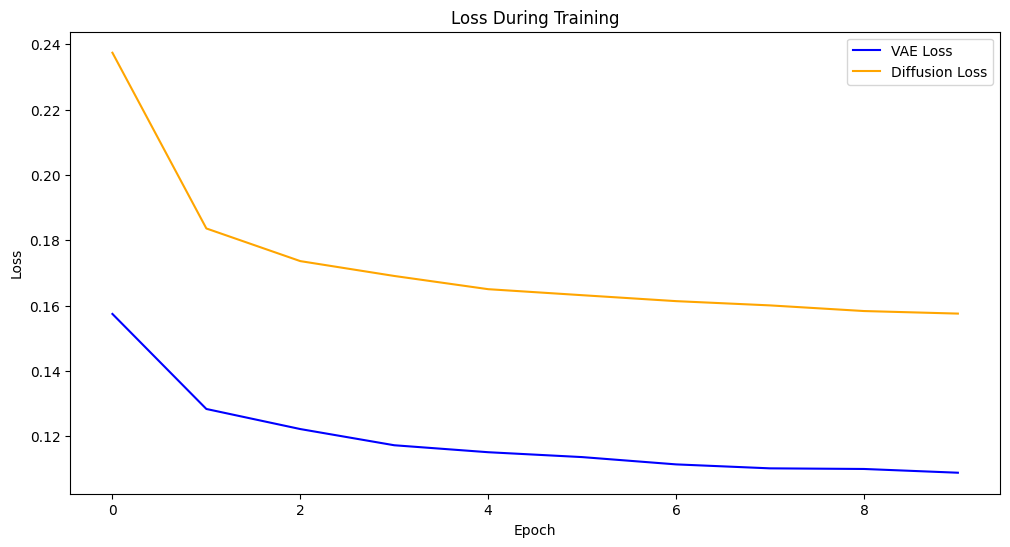

In [4]:
    # Plotting the losses
    plt.figure(figsize=(12, 6))
    plt.plot(vae_losses, label='VAE Loss', color='blue')
    plt.plot(diffusion_losses, label='Diffusion Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()
    plt.show()


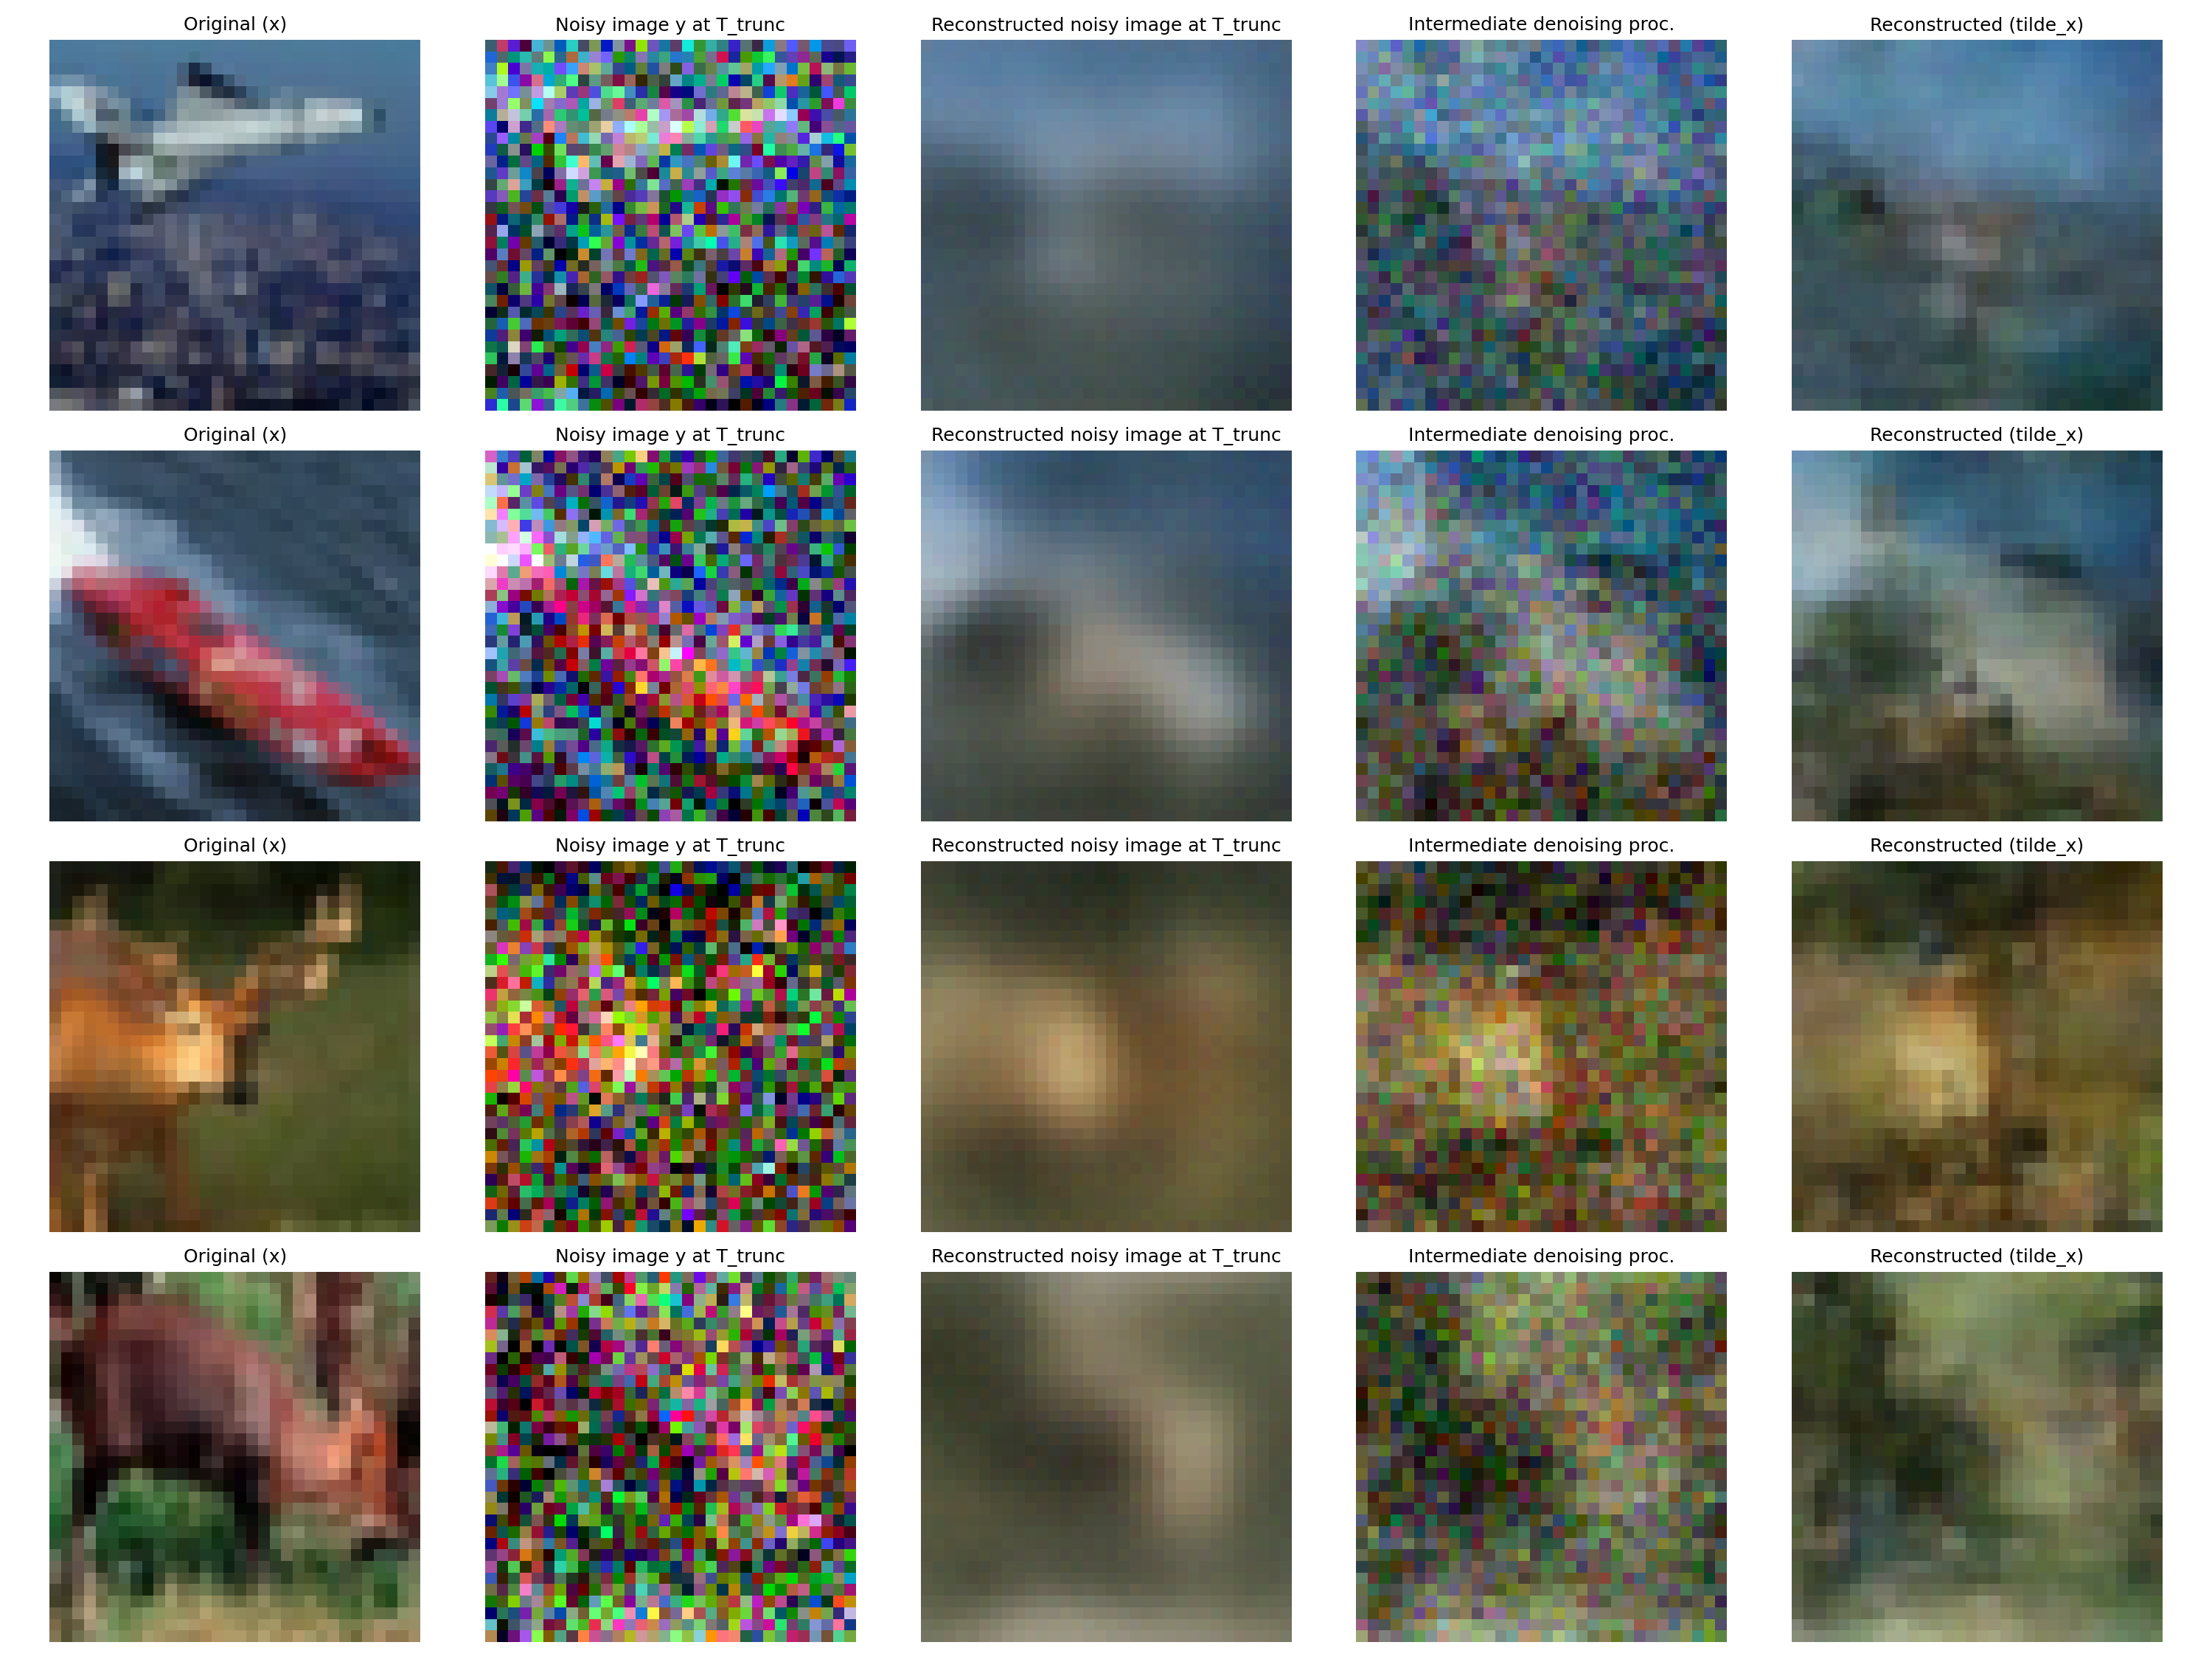

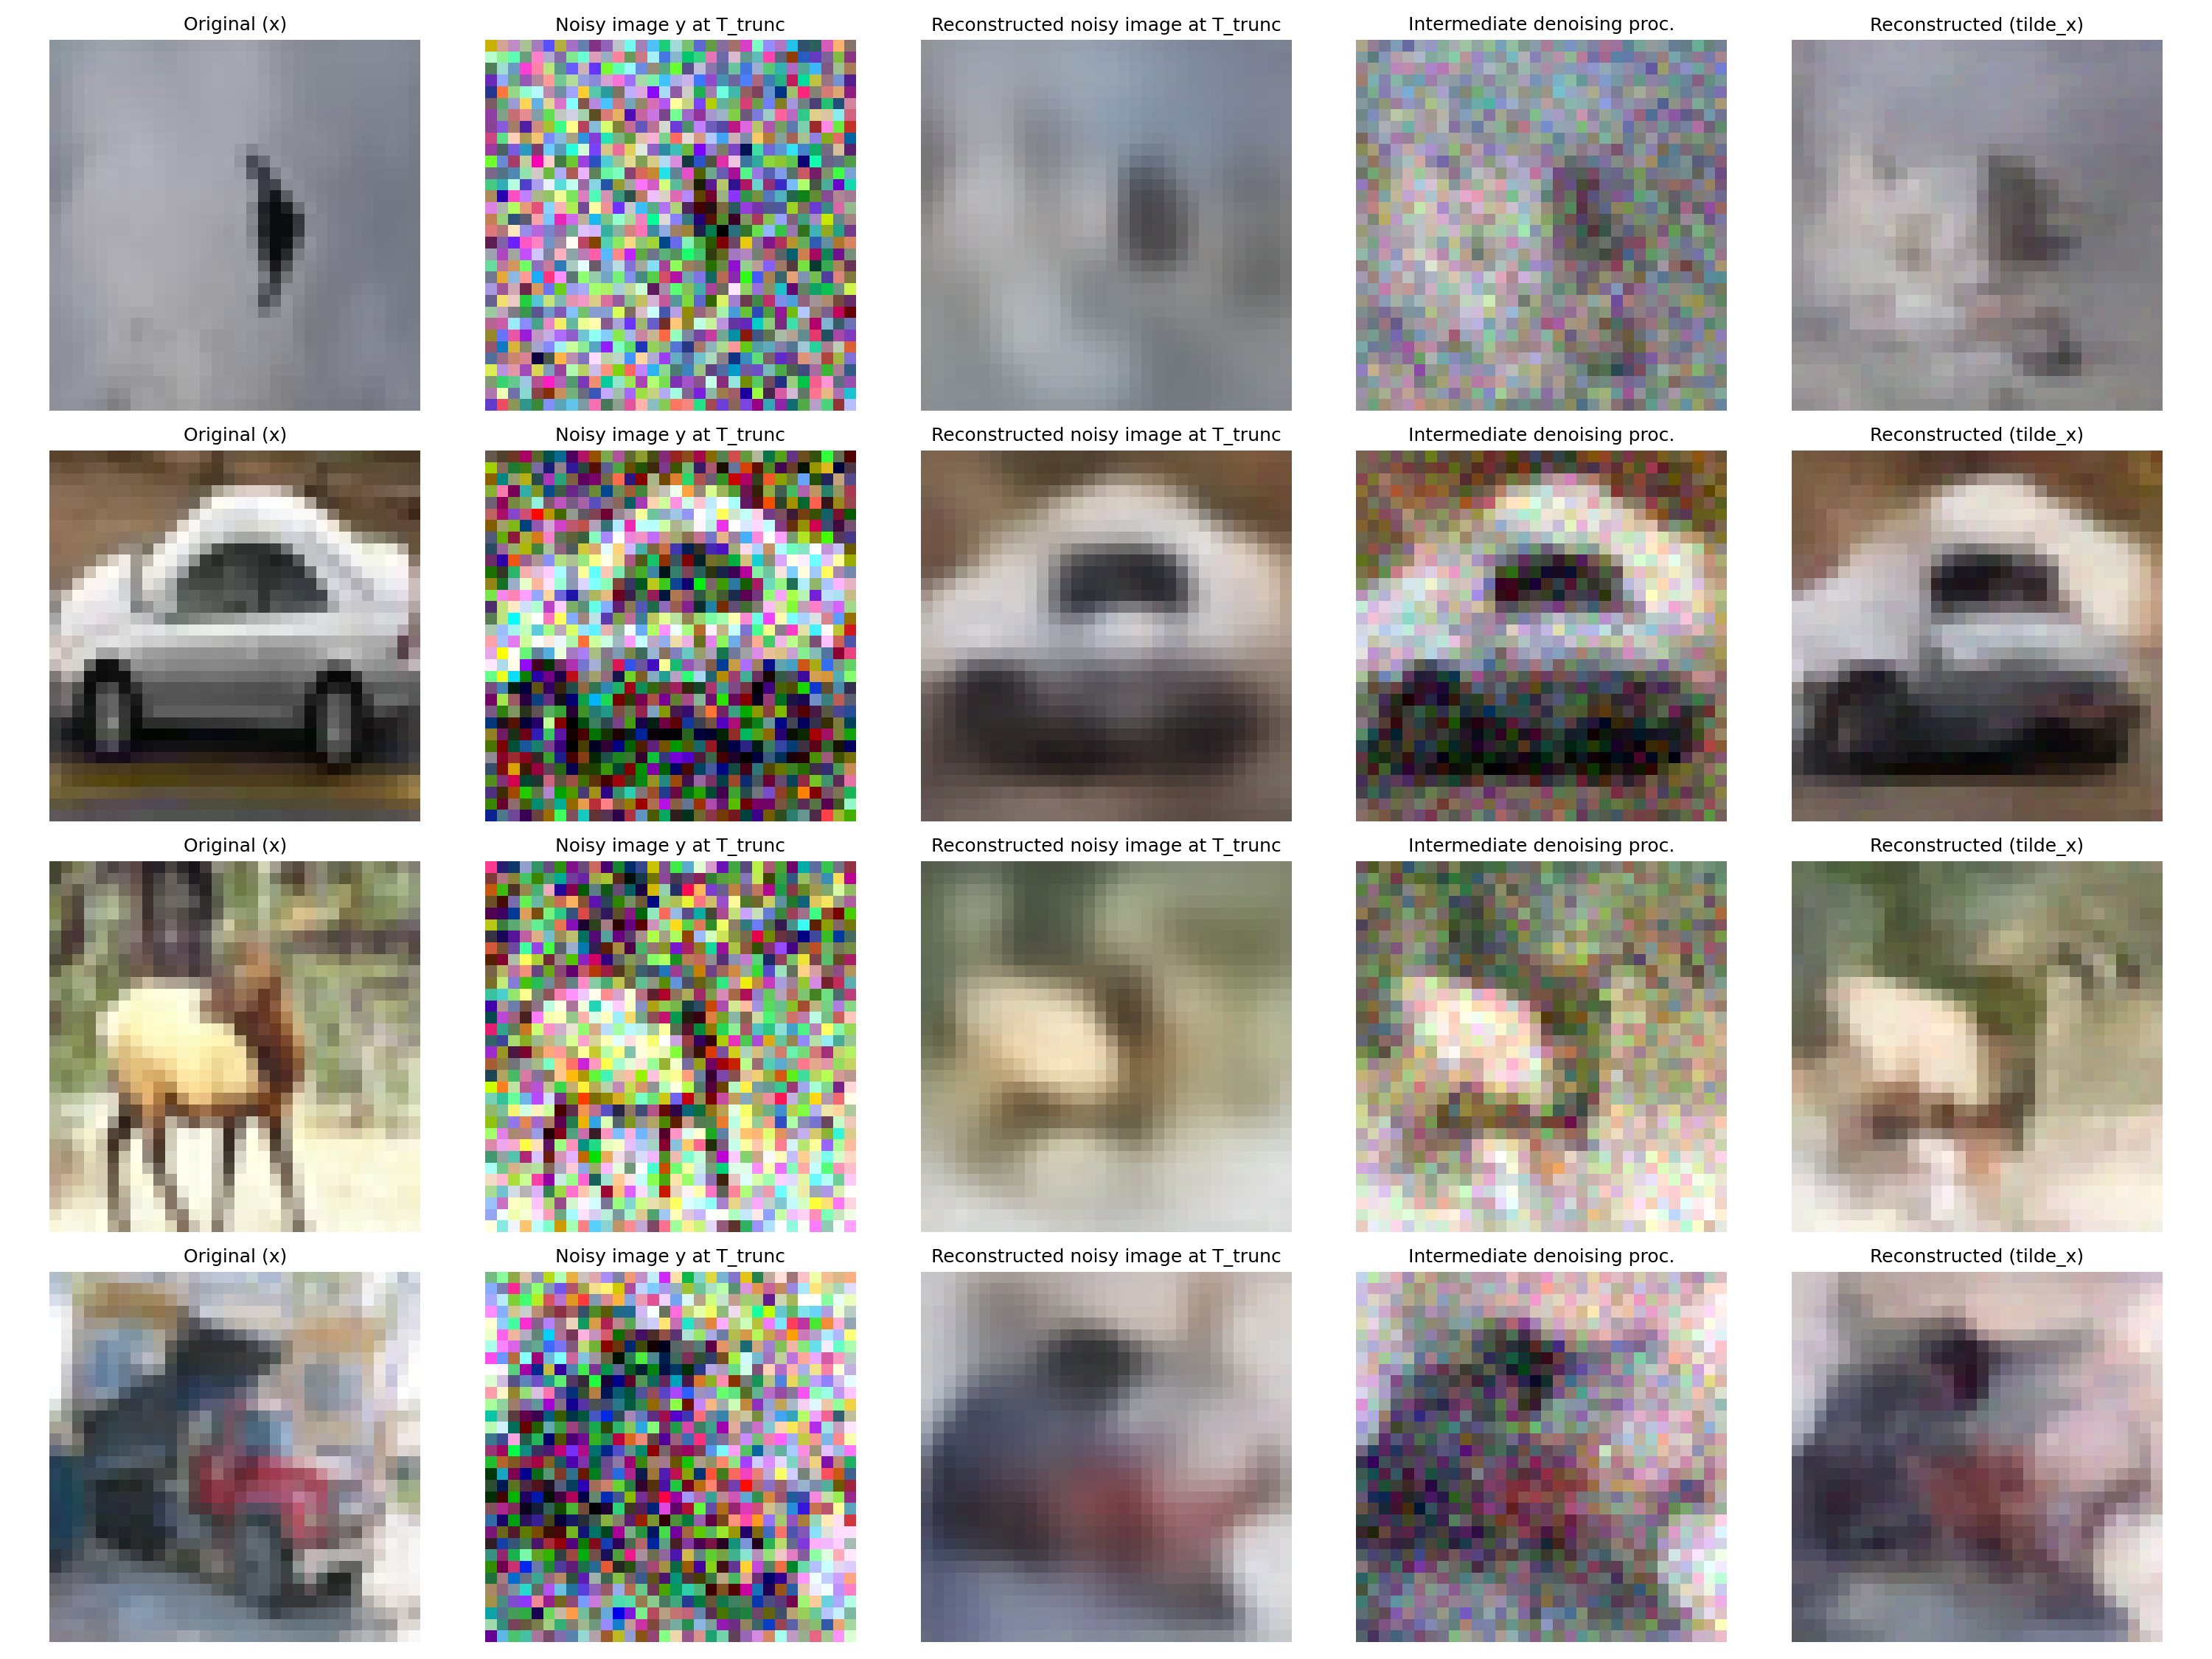

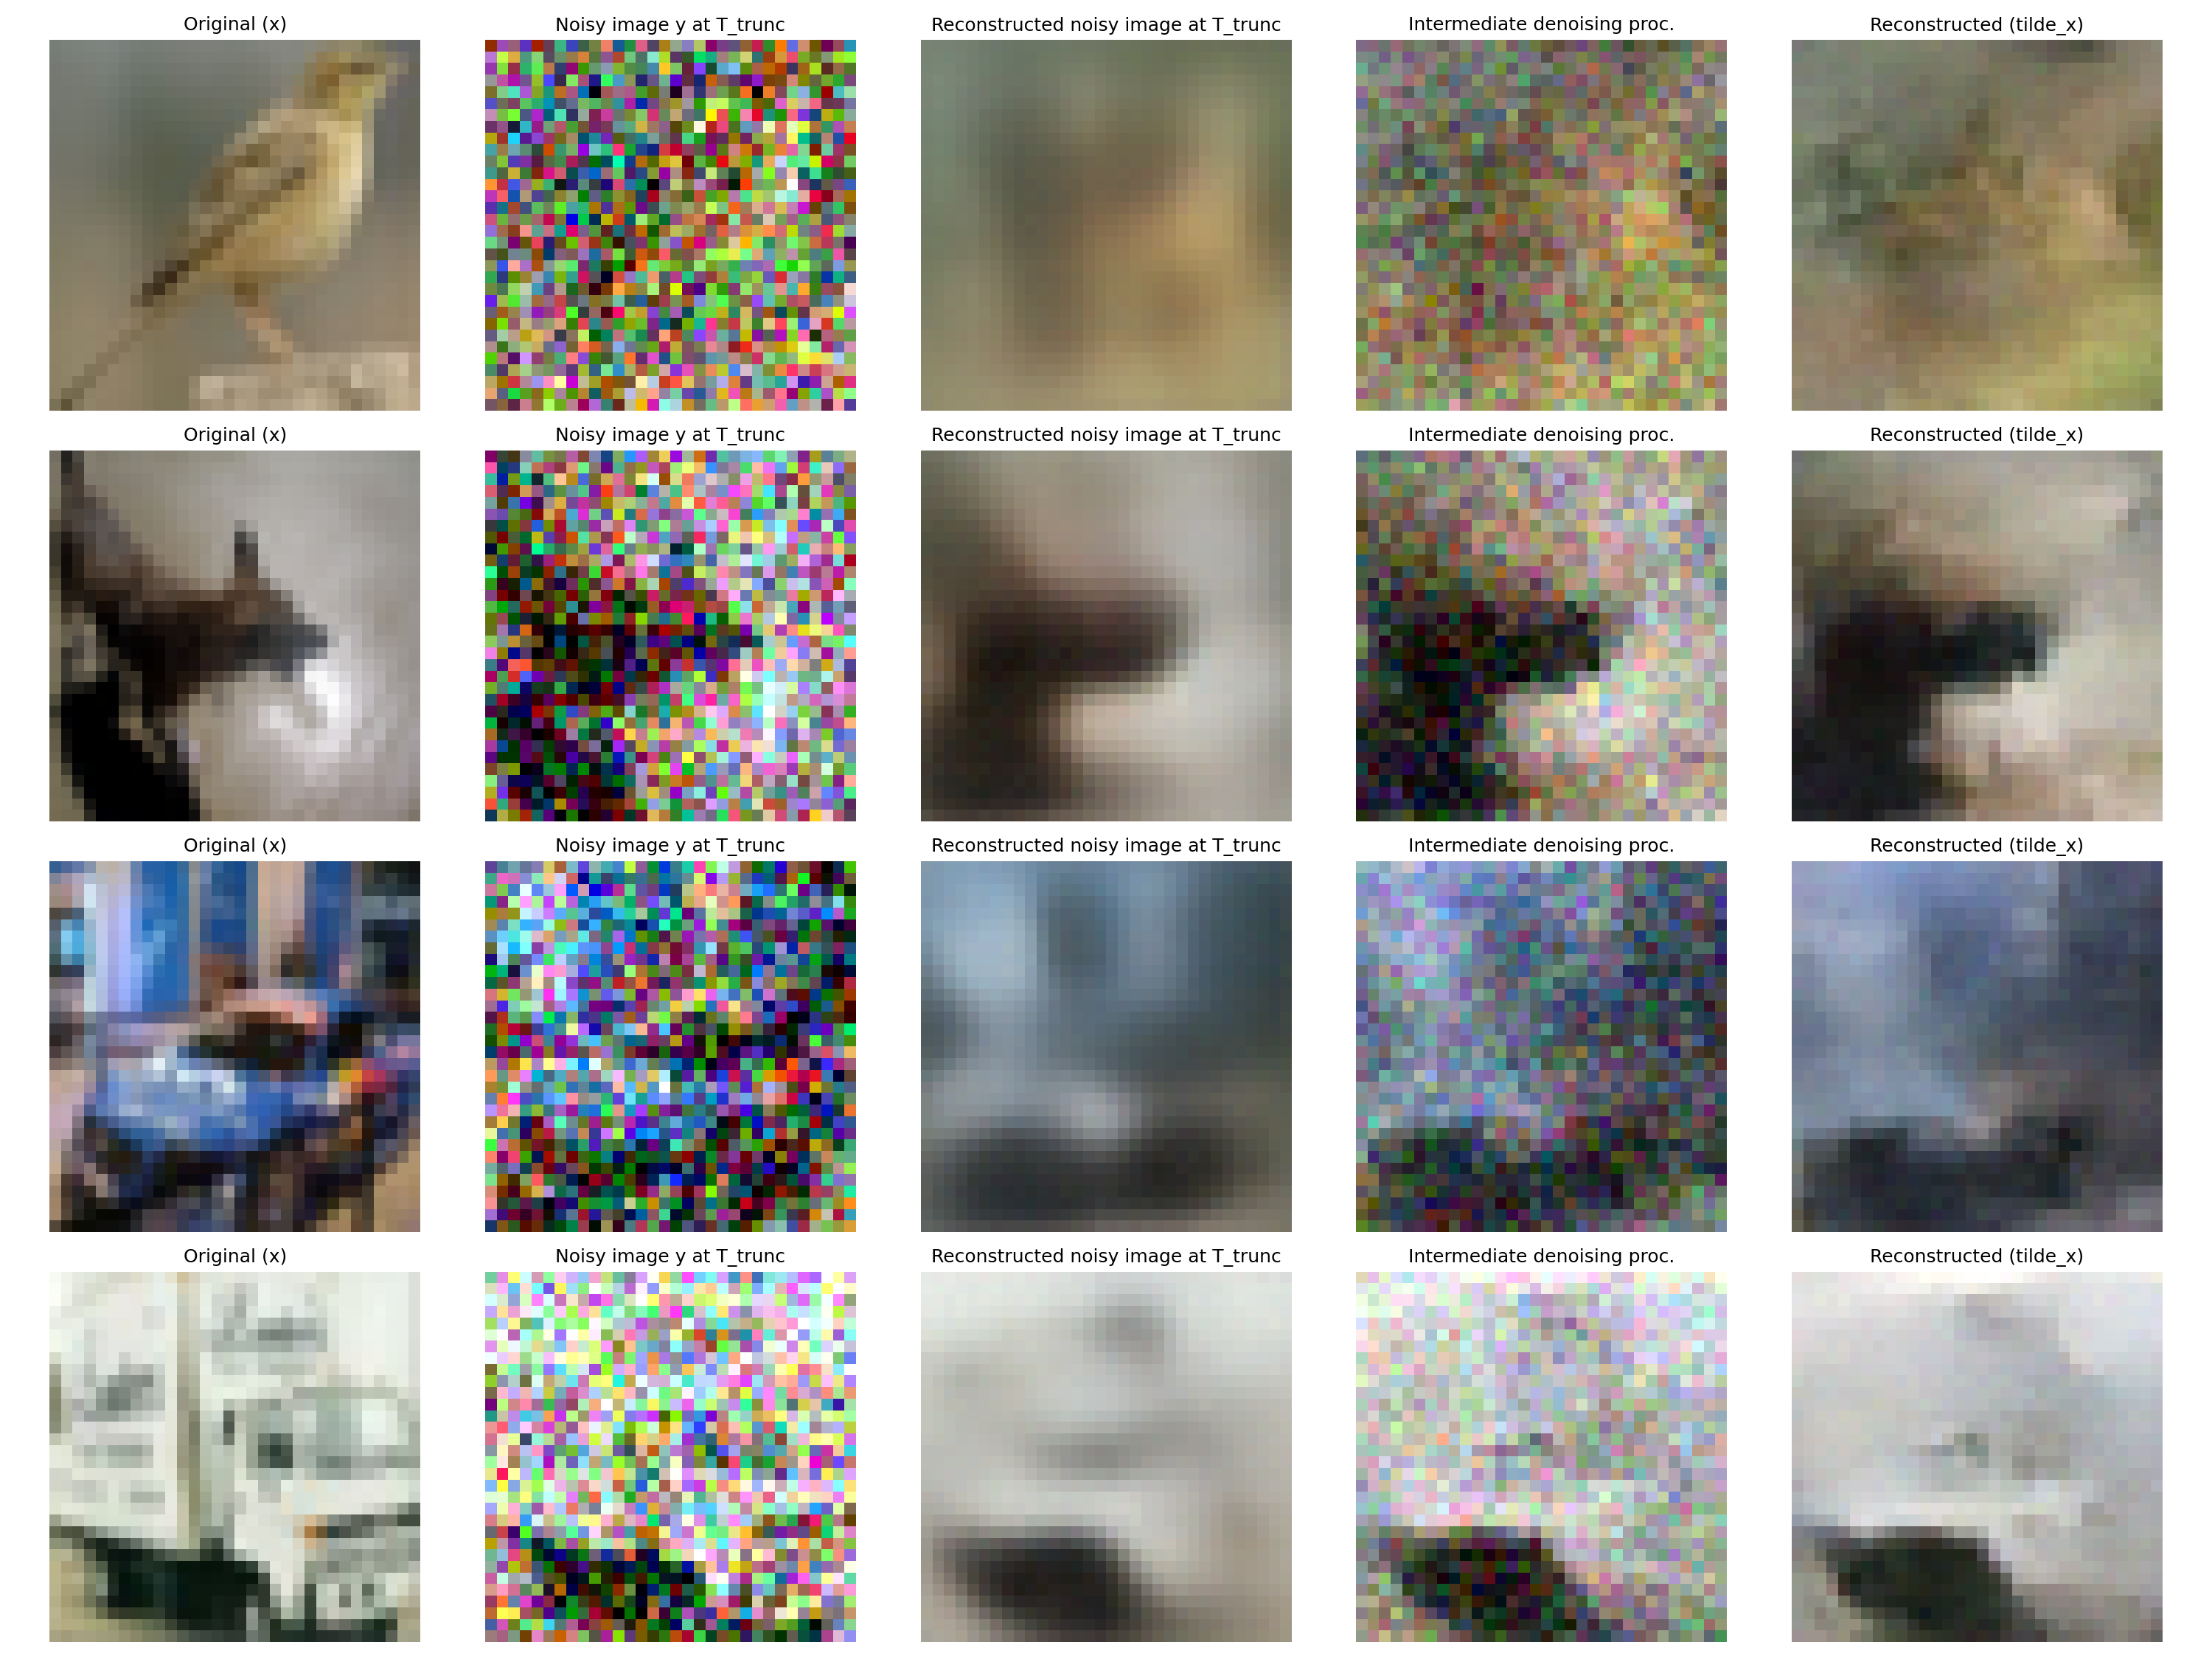

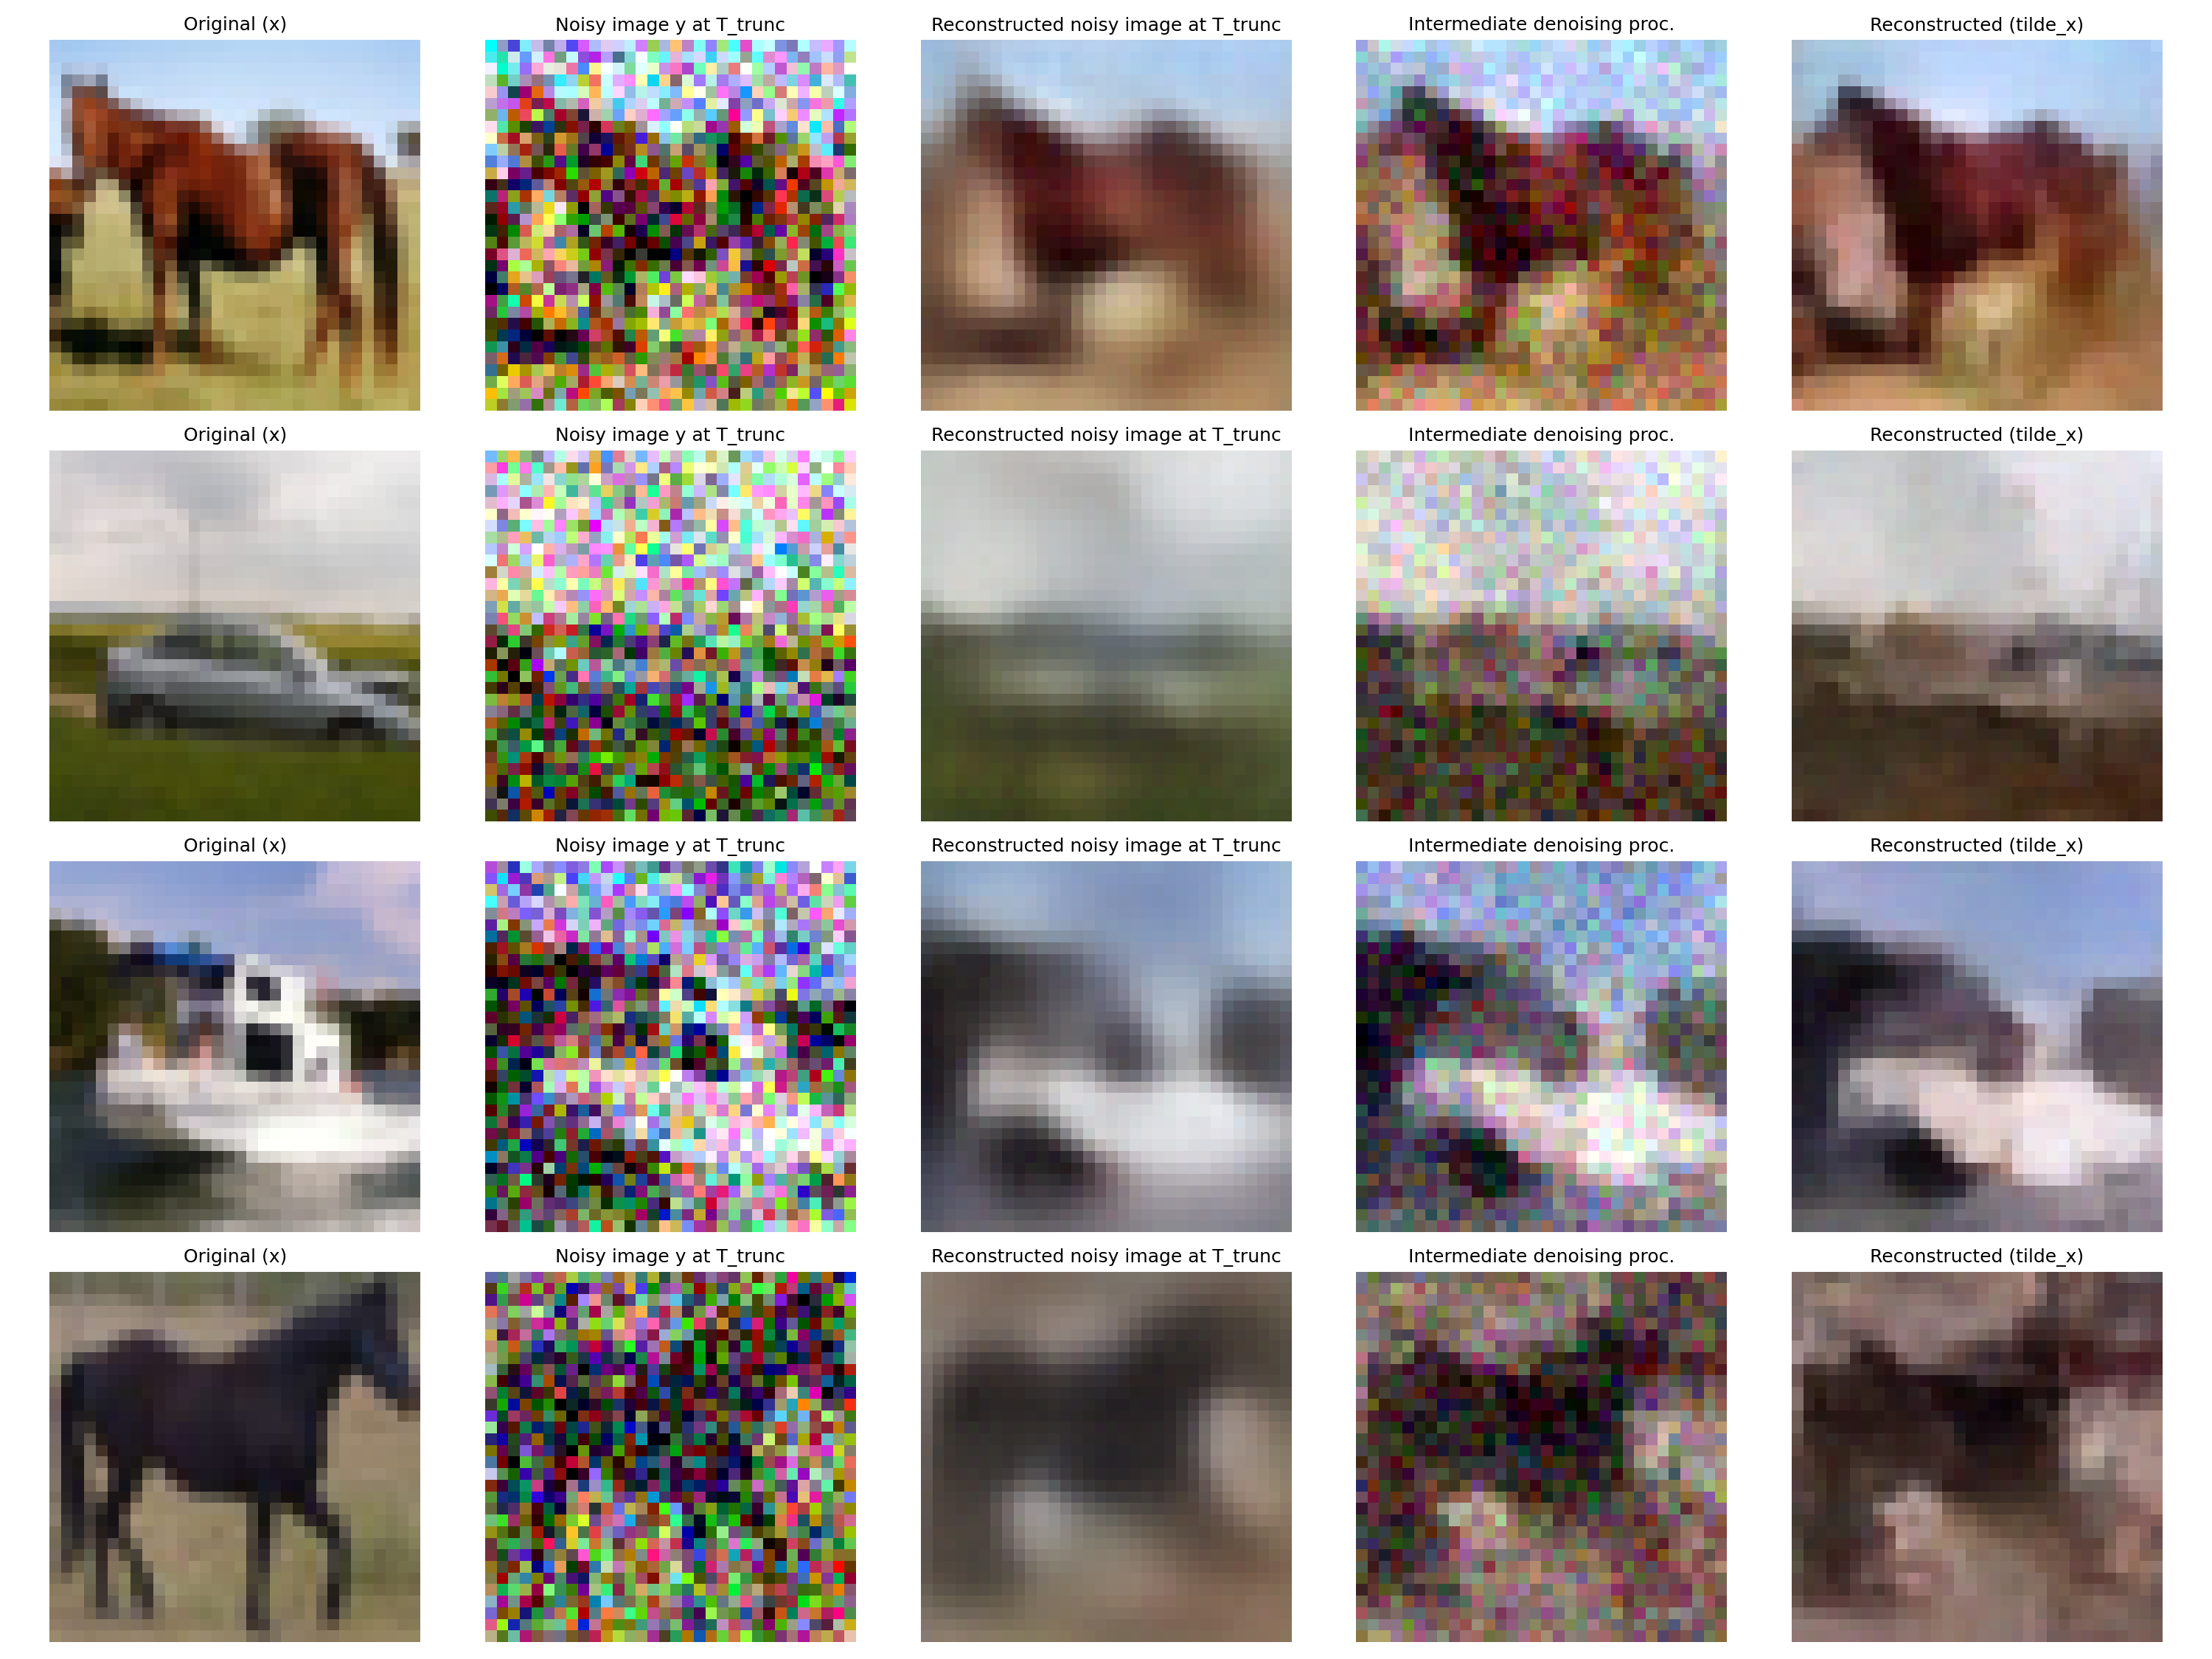

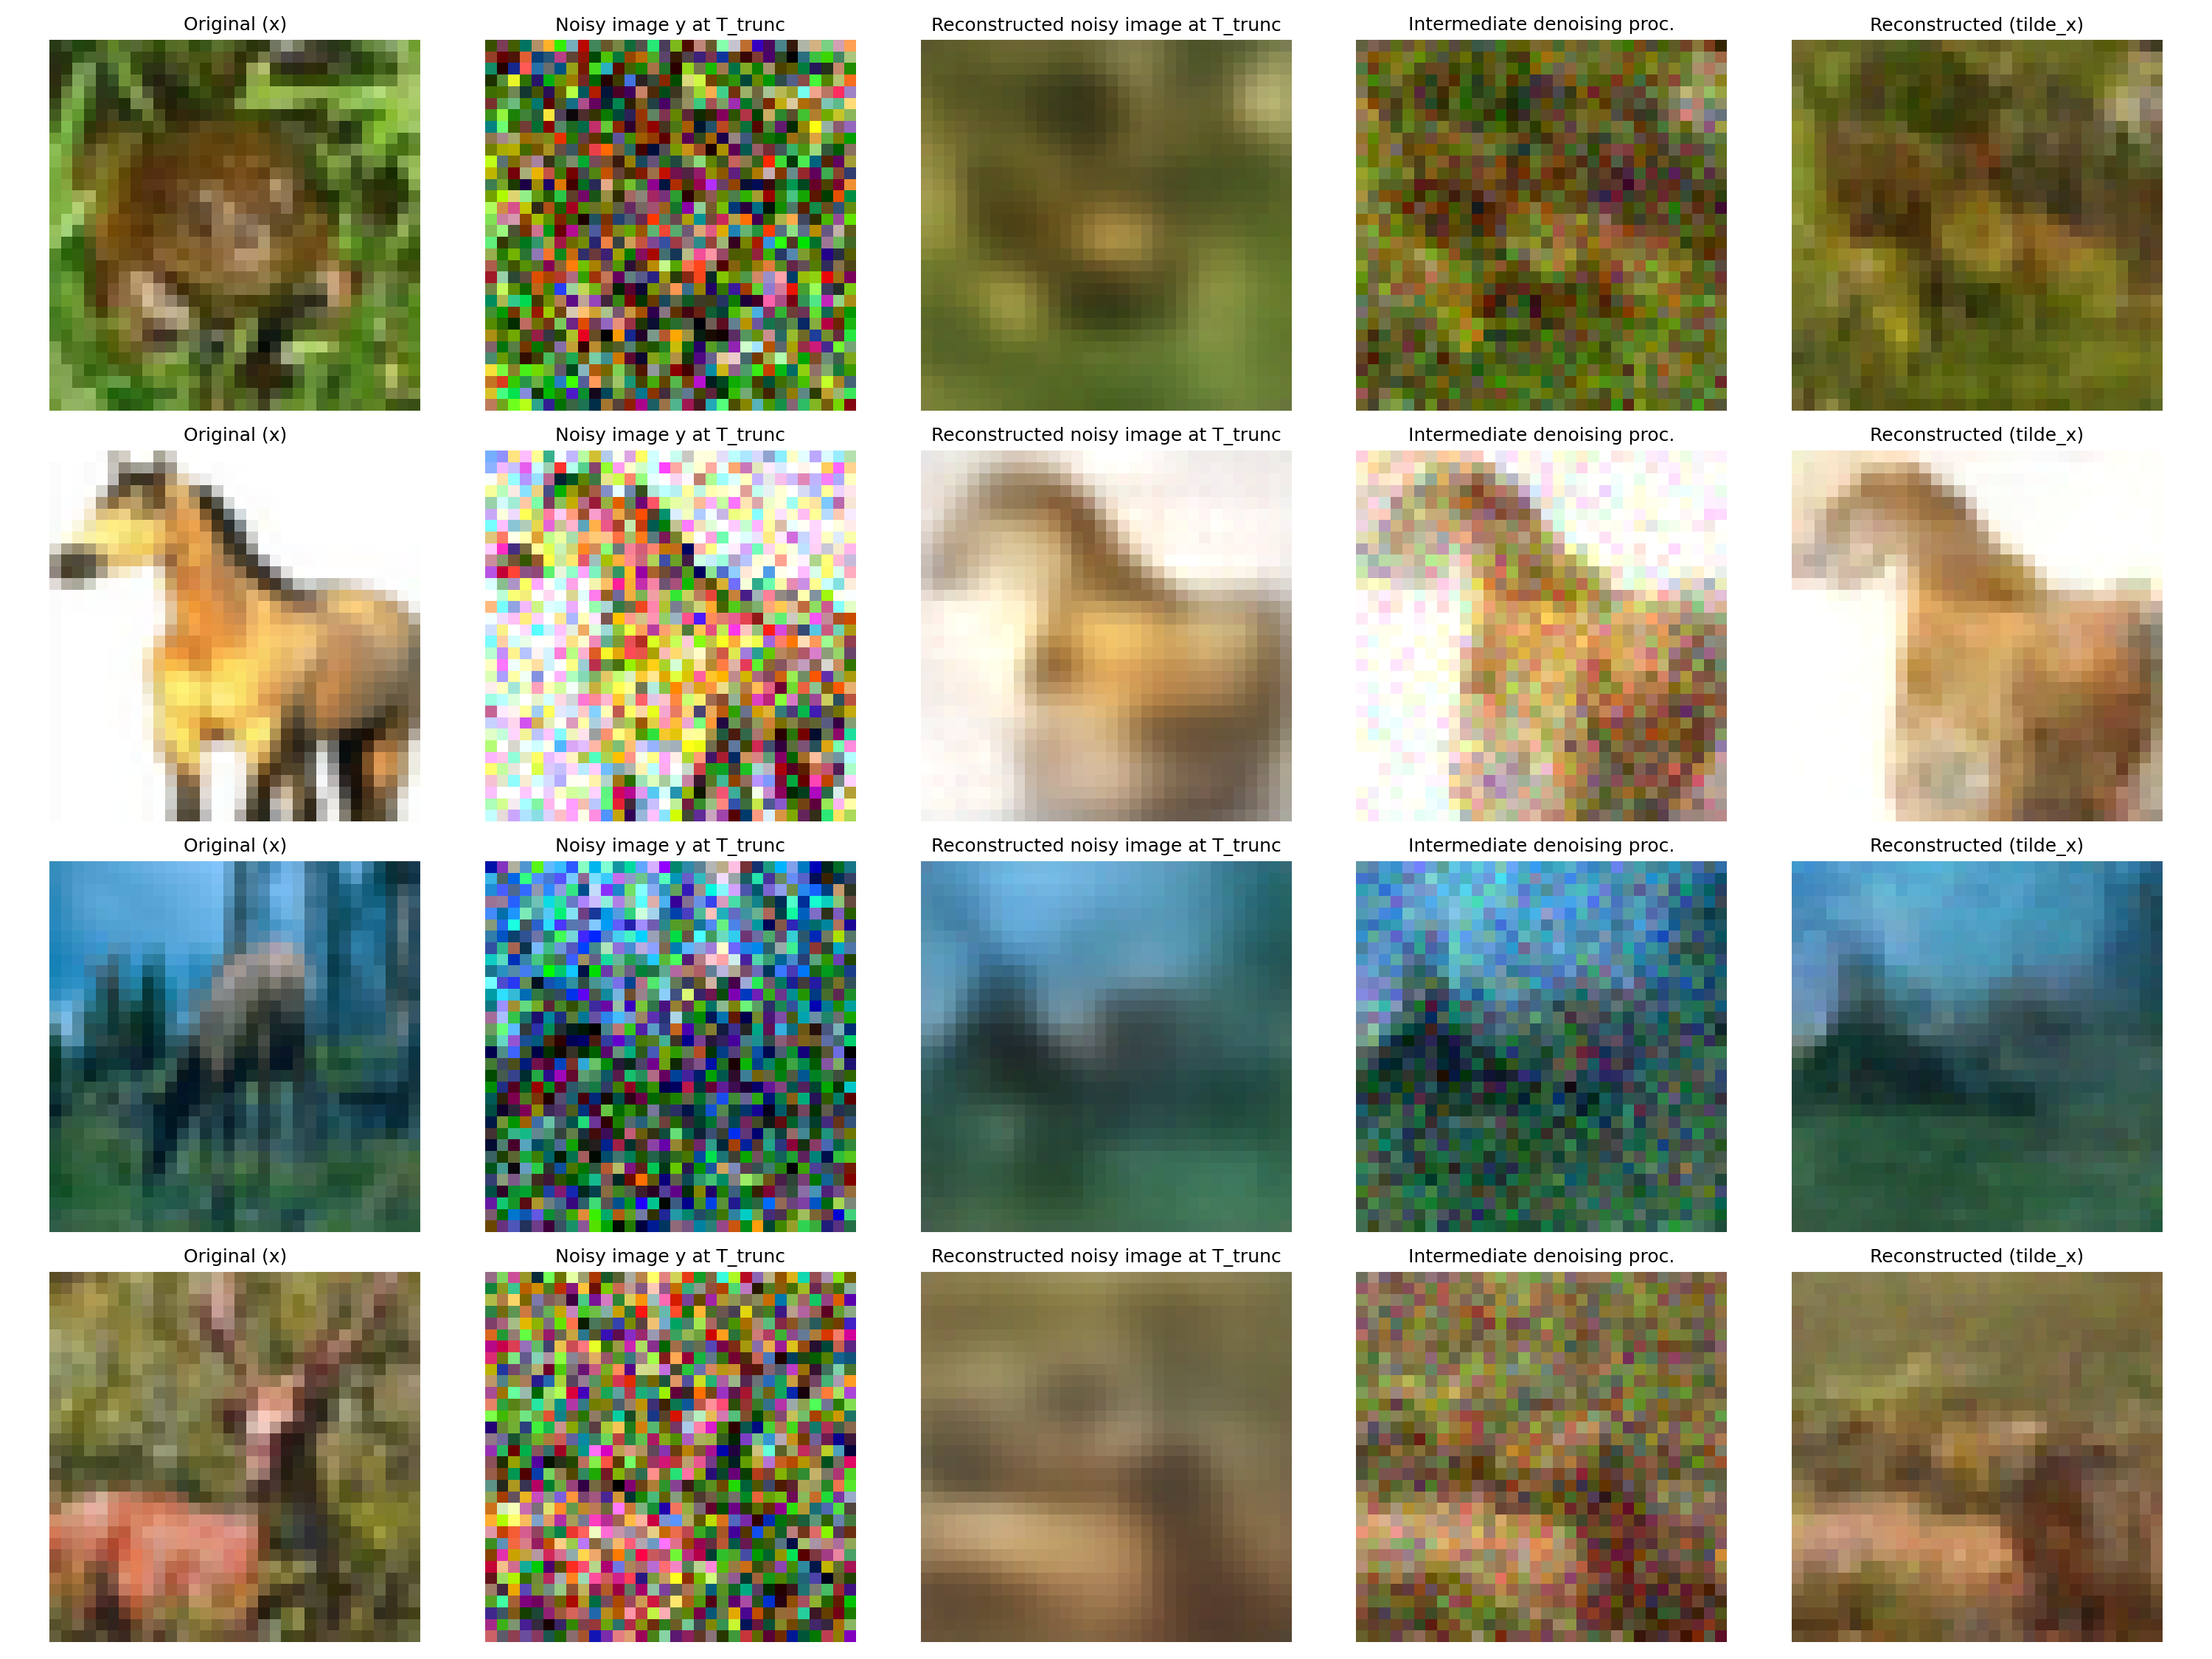

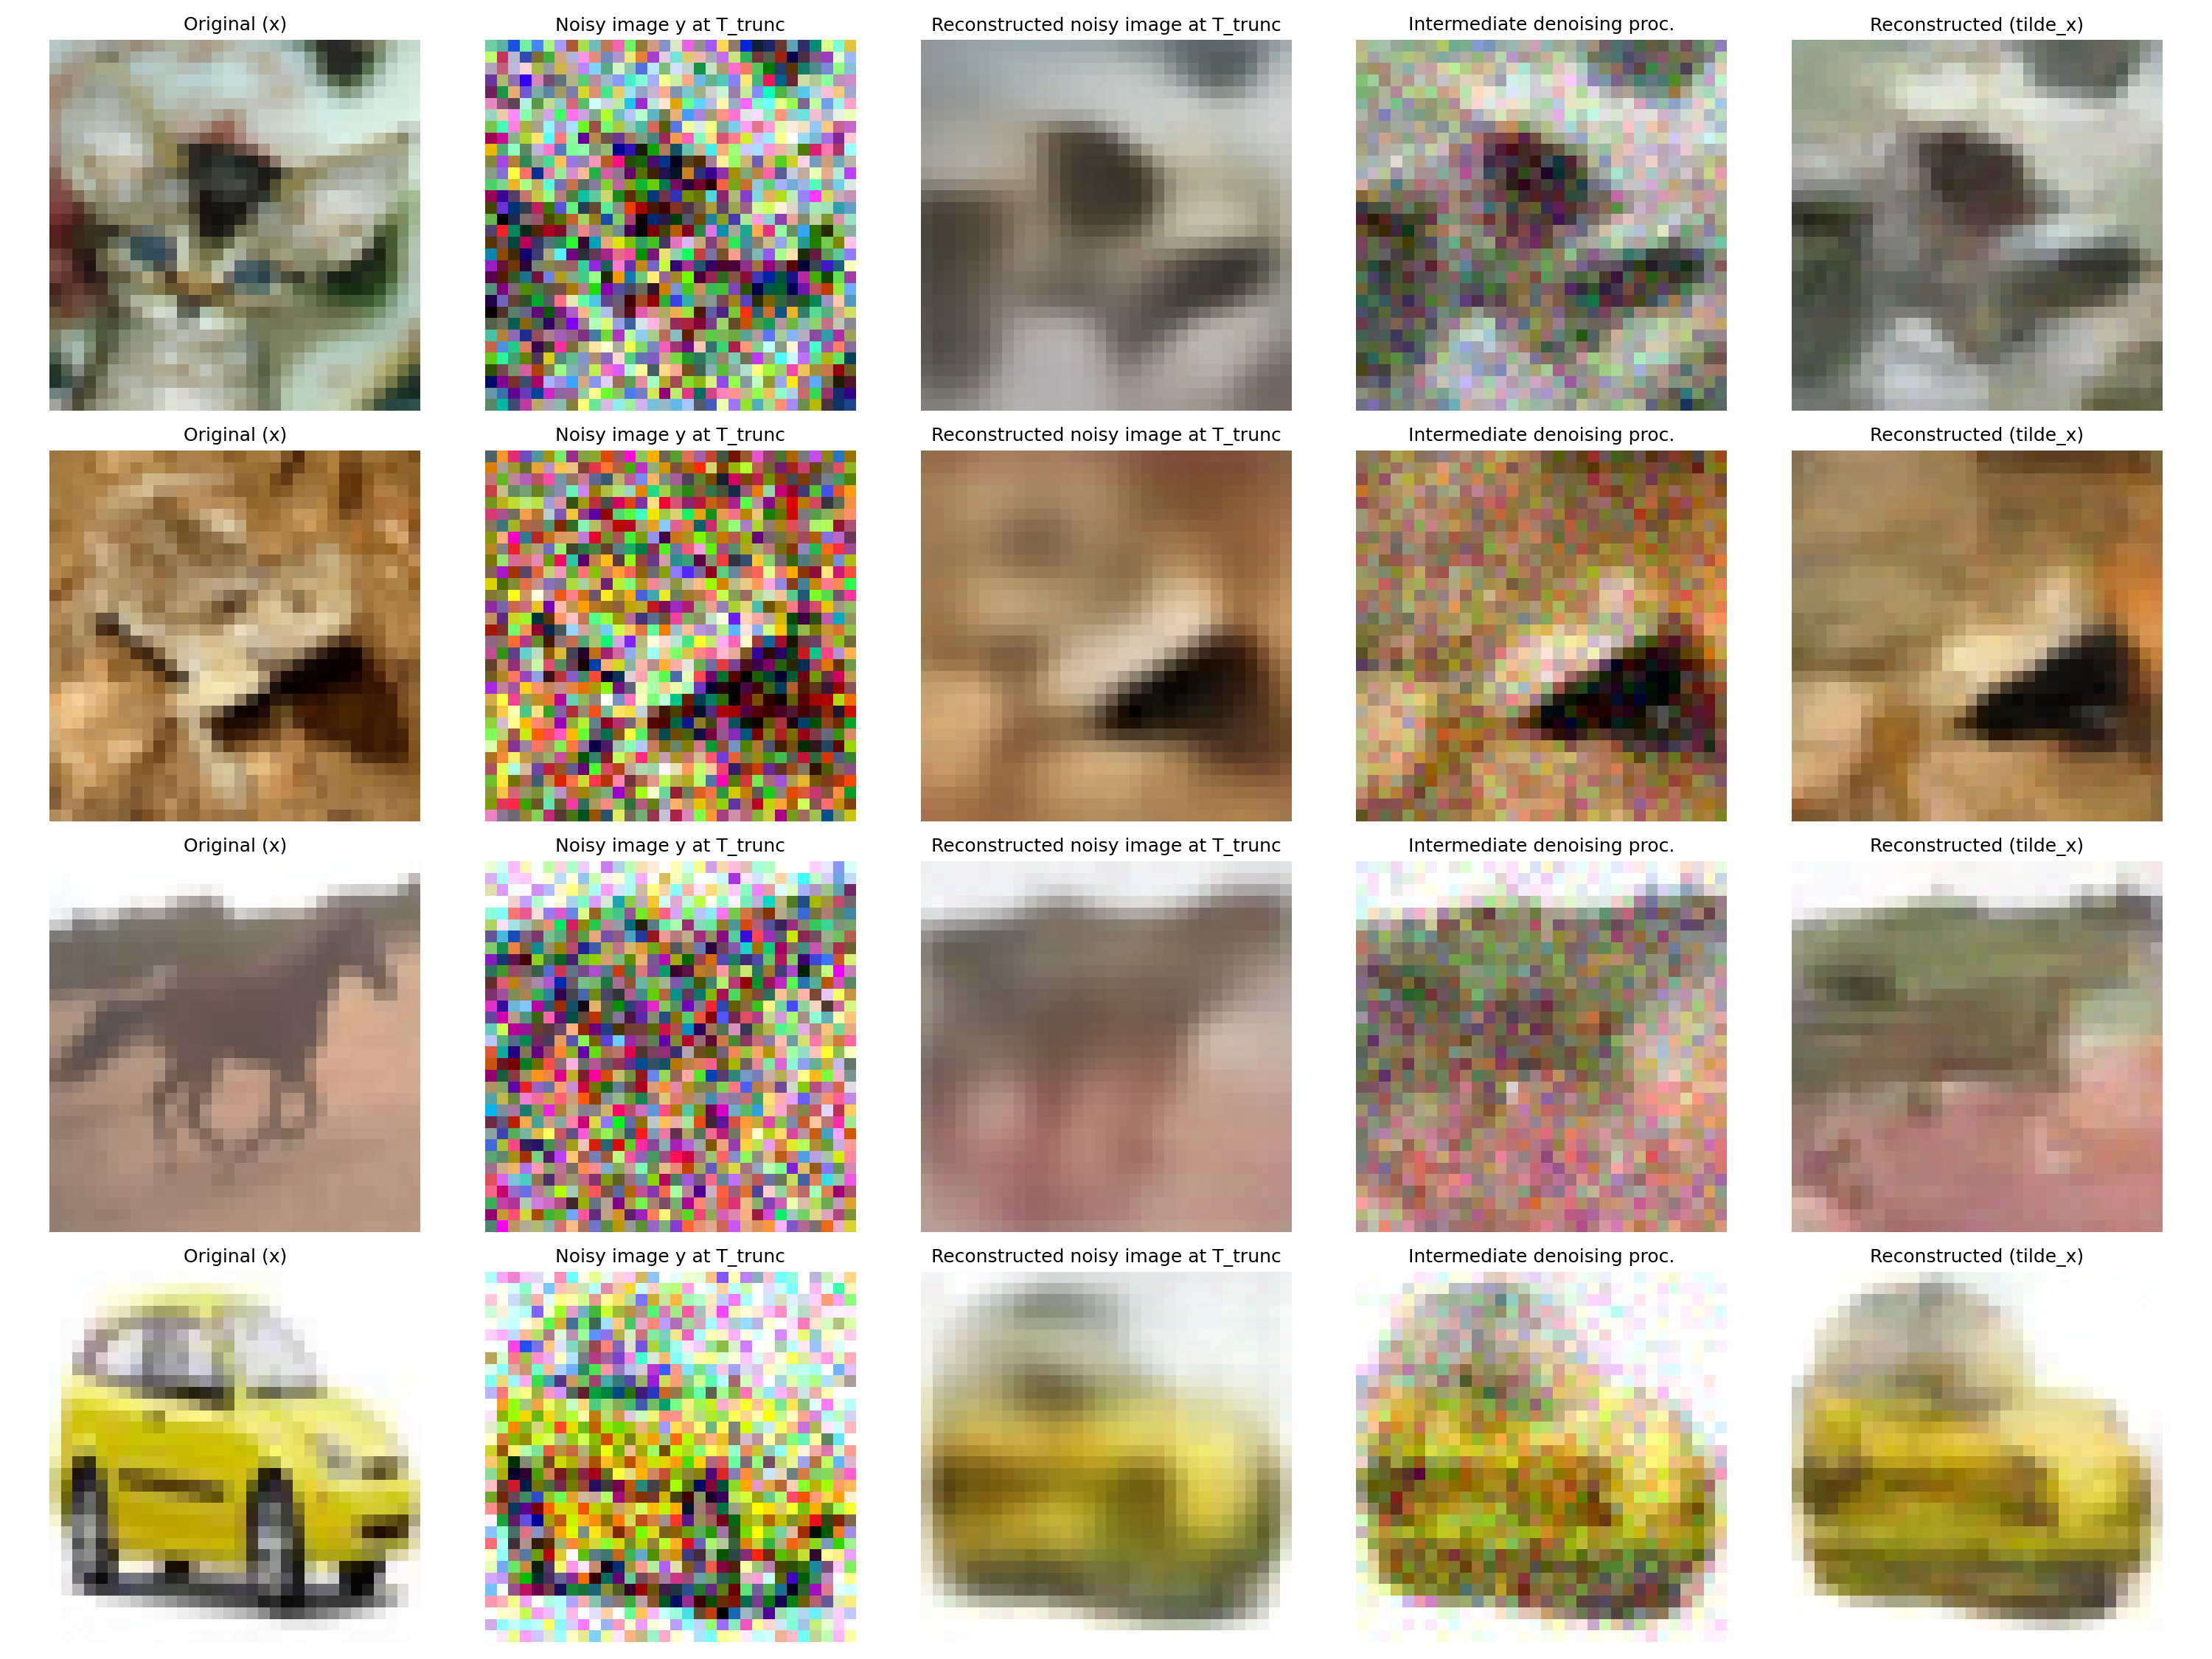

In [5]:
from IPython.display import Image, display
import glob

# Display all reconstruction images
for image_path in sorted(glob.glob('reconstruction_epoch_*.png')):
    display(Image(filename=image_path))

In [10]:
def calcualte_metrics(model, diffusion, images):
  model.eval()
  with torch.no_grad():
      t = torch.full((images.shape[0],), diffusion.diffusion_steps-1, device=images.device)
      noisy_images, _ = diffusion.forward_diffusion(images, t)
      reconstructed, reconstruction_steps = diffusion.reverse_process(model, noisy_images)
      snr = calculate_snr(images, reconstructed)
      fid = compute_fid(images, reconstructed)
      return snr, fid



def visualize_reconstruction(model, diffusion, images, epoch):
    model.eval()
    with torch.no_grad():
        t = torch.full((images.shape[0],), diffusion.diffusion_steps-1, device=images.device)
        noisy_images, _ = diffusion.forward_diffusion(images, t)
        reconstructed, reconstruction_steps = diffusion.reverse_process(model, noisy_images)


        def denormalize(x):
            return (x * 0.5 + 0.5).clamp(0, 1)

        fig, axes = plt.subplots(4, 4, figsize=(20, 20))
        for i in range(4):
            stages = [images[i], noisy_images[i],
                     reconstruction_steps[len(reconstruction_steps)//2][i],
                     reconstructed[i]]
            titles = ['Original', 'Noisy', 'Intermediate', 'Reconstructed']

            for j, (img, title) in enumerate(zip(stages, titles)):
                axes[i, j].imshow(denormalize(img.cpu()).permute(1, 2, 0))
                axes[i, j].set_title(title)
                axes[i, j].axis('off')

        plt.tight_layout()
        plt.savefig(f'reconstruction_epoch_diffusion_{epoch}.png')
        plt.close()


def train_improved_model(num_epochs=10, batch_size=BATCH_SIZE, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    model = ImprovedUNet().to(device)
    diffusion = ImprovedDiffusion(device=device)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    losses = []
    snr_values = []
    fid_values = []


    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)
            t = torch.randint(0, diffusion.diffusion_steps, (images.shape[0],), device=device)

            noisy_images, noise = diffusion.forward_diffusion(images, t)
            predicted_noise = model(noisy_images, t)
            loss = nn.MSELoss()(predicted_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Batch {i}, Loss: {loss.item():.4f}')

        scheduler.step()
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

        snr, fid = calcualte_metrics(model, diffusion, next(iter(dataloader))[0][:16].to(device))
        snr_values.append(snr)
        fid_values.append(fid)

        if (epoch + 1) % 2 == 0:
            visualize_reconstruction(model, diffusion, next(iter(dataloader))[0][:4].to(device), epoch+1)

    return model, diffusion, losses, snr_values, fid_values

if __name__ == "__main__":
    model, diffusion, losses_ddpm, snr_values_ddpm, fid_values_ddpm = train_improved_model()

Using device: cuda
Files already downloaded and verified
Starting training...
Epoch 1, Batch 0, Loss: 1.1832
Epoch 1, Batch 100, Loss: 0.2709
Epoch 1, Batch 200, Loss: 0.1820
Epoch 1, Batch 300, Loss: 0.1461
Epoch 1, Batch 400, Loss: 0.1880
Epoch 1, Batch 500, Loss: 0.1930
Epoch 1, Batch 600, Loss: 0.1836
Epoch 1, Batch 700, Loss: 0.1652
Epoch 1, Batch 800, Loss: 0.1193
Epoch 1, Batch 900, Loss: 0.1401
Epoch 1, Batch 1000, Loss: 0.1264
Epoch 1, Batch 1100, Loss: 0.1034
Epoch 1, Batch 1200, Loss: 0.1560
Epoch 1, Batch 1300, Loss: 0.1406
Epoch 1, Batch 1400, Loss: 0.1705
Epoch 1, Batch 1500, Loss: 0.1619
Epoch 1, Average Loss: 0.1743
Epoch 2, Batch 0, Loss: 0.1351
Epoch 2, Batch 100, Loss: 0.1095
Epoch 2, Batch 200, Loss: 0.1107
Epoch 2, Batch 300, Loss: 0.0942
Epoch 2, Batch 400, Loss: 0.0942
Epoch 2, Batch 500, Loss: 0.1530
Epoch 2, Batch 600, Loss: 0.1439
Epoch 2, Batch 700, Loss: 0.1032
Epoch 2, Batch 800, Loss: 0.1812
Epoch 2, Batch 900, Loss: 0.1088
Epoch 2, Batch 1000, Loss: 0.129

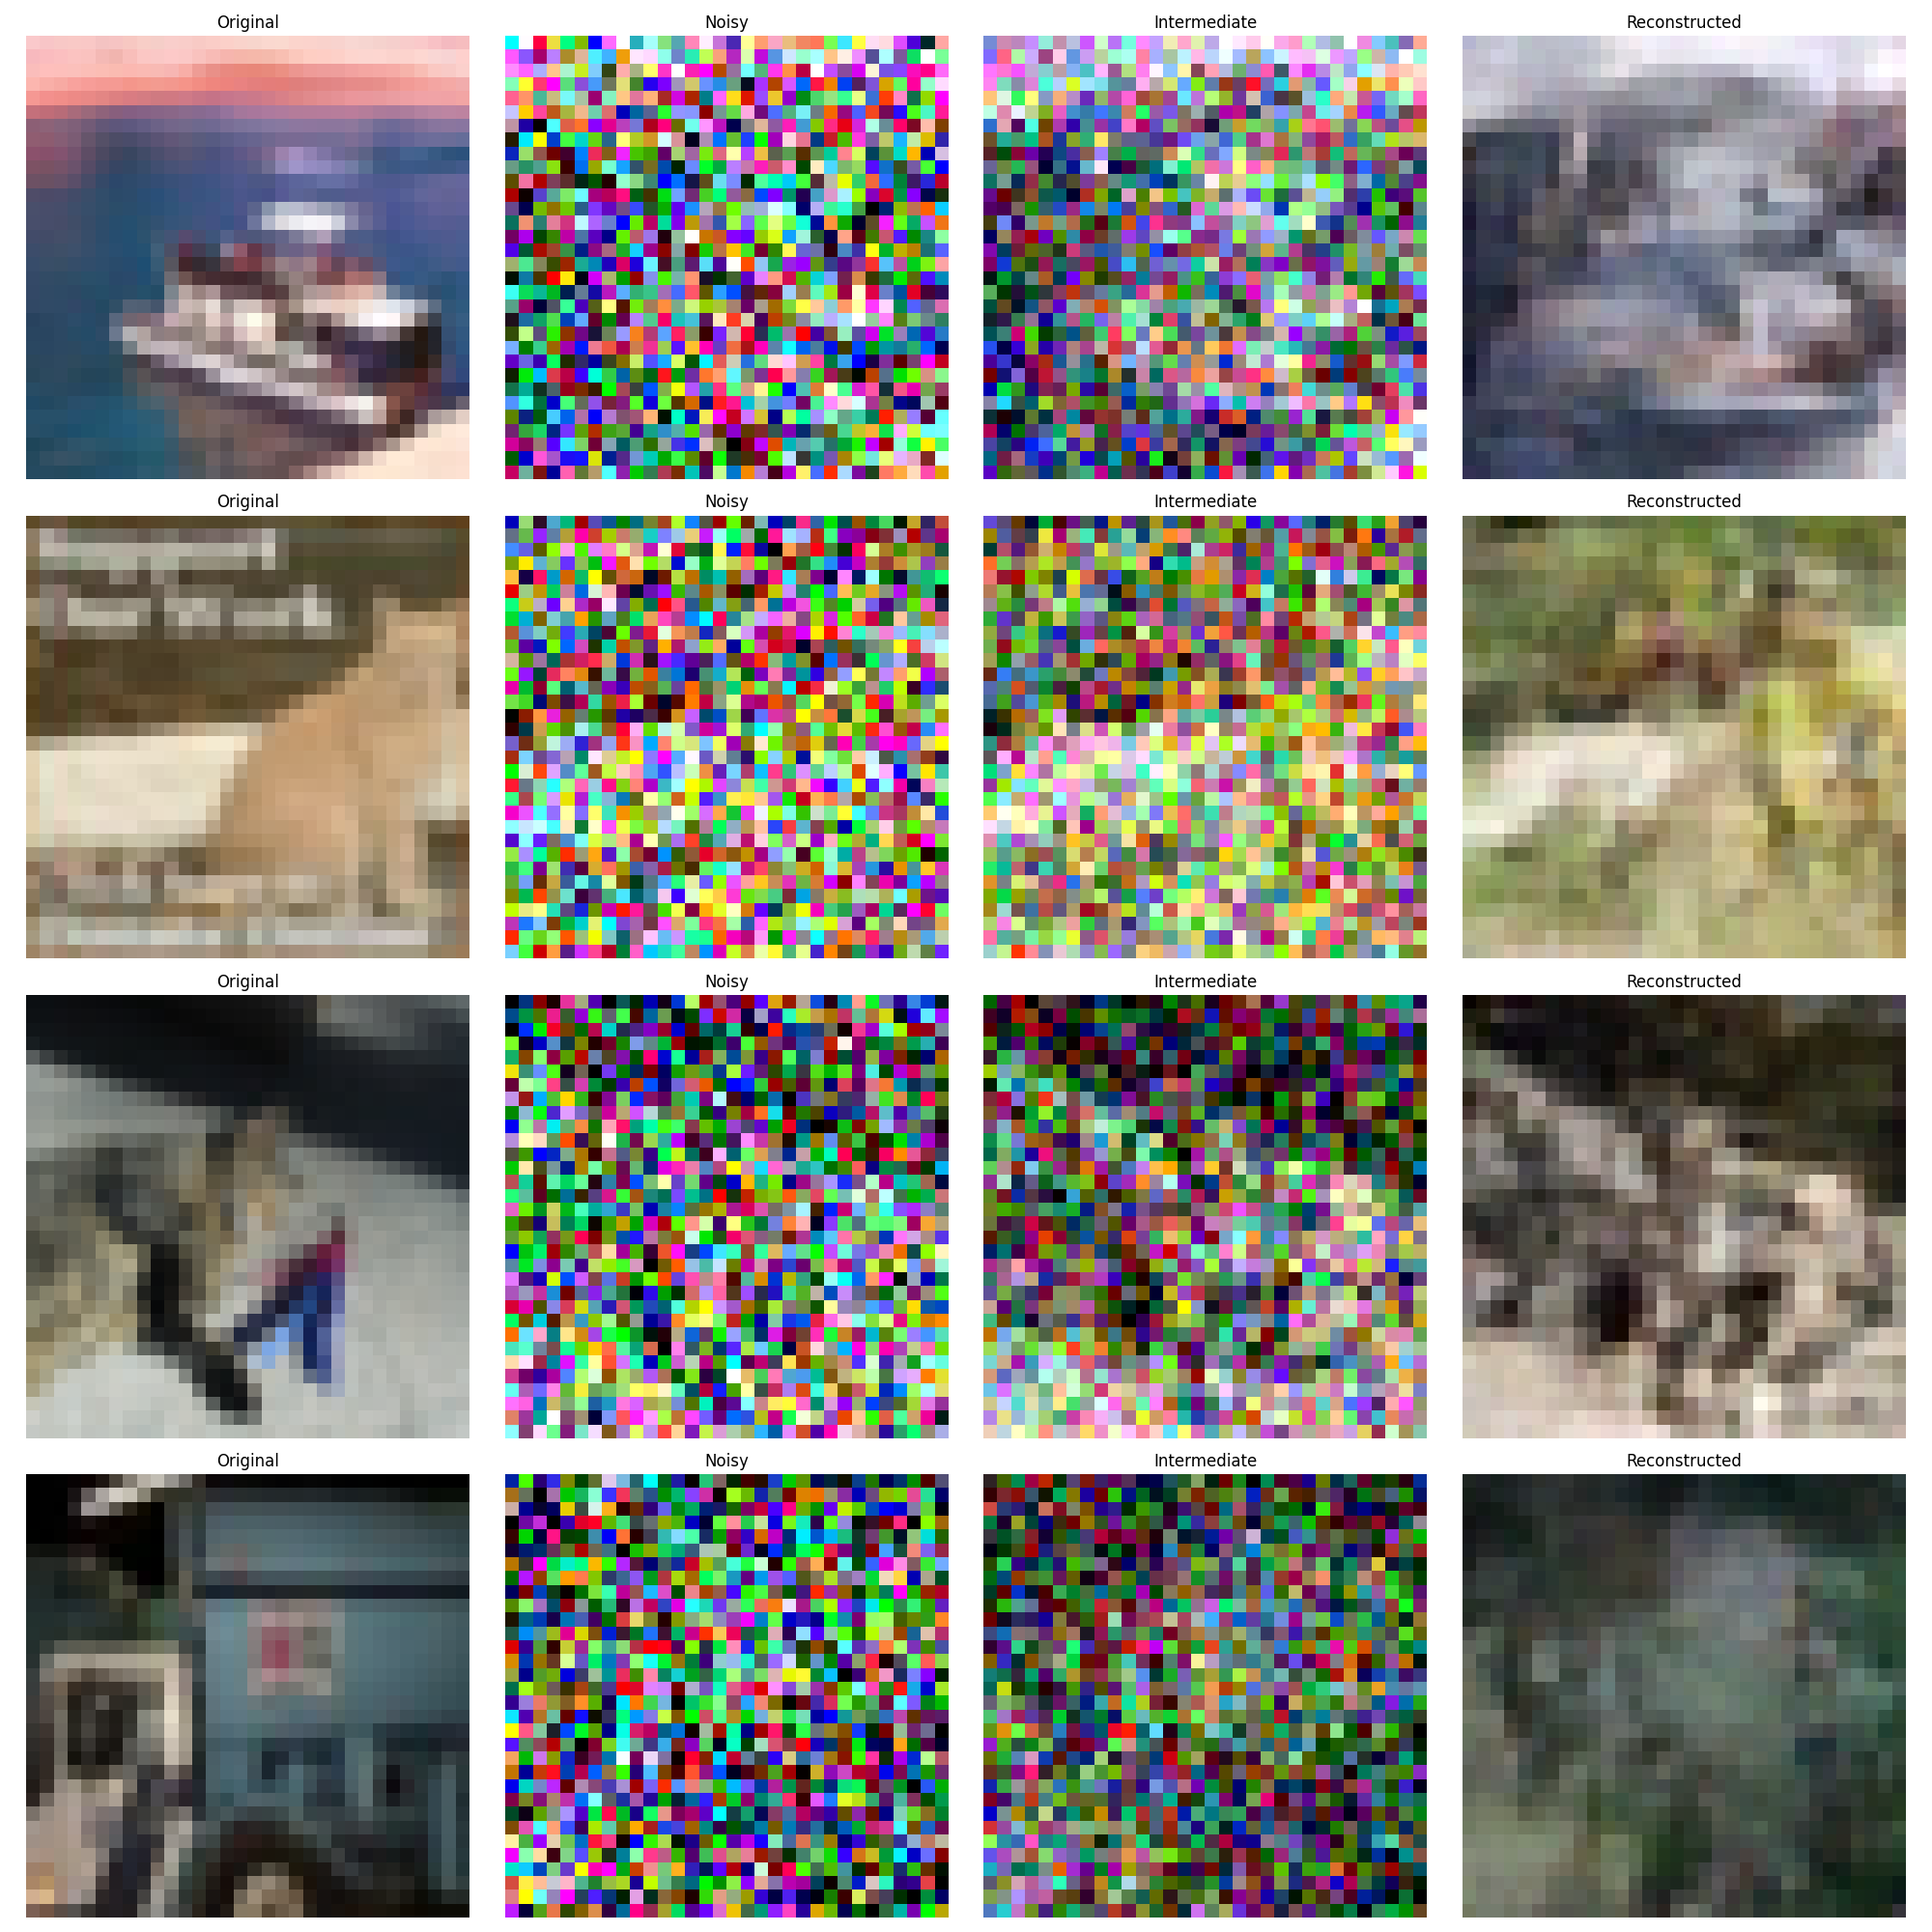

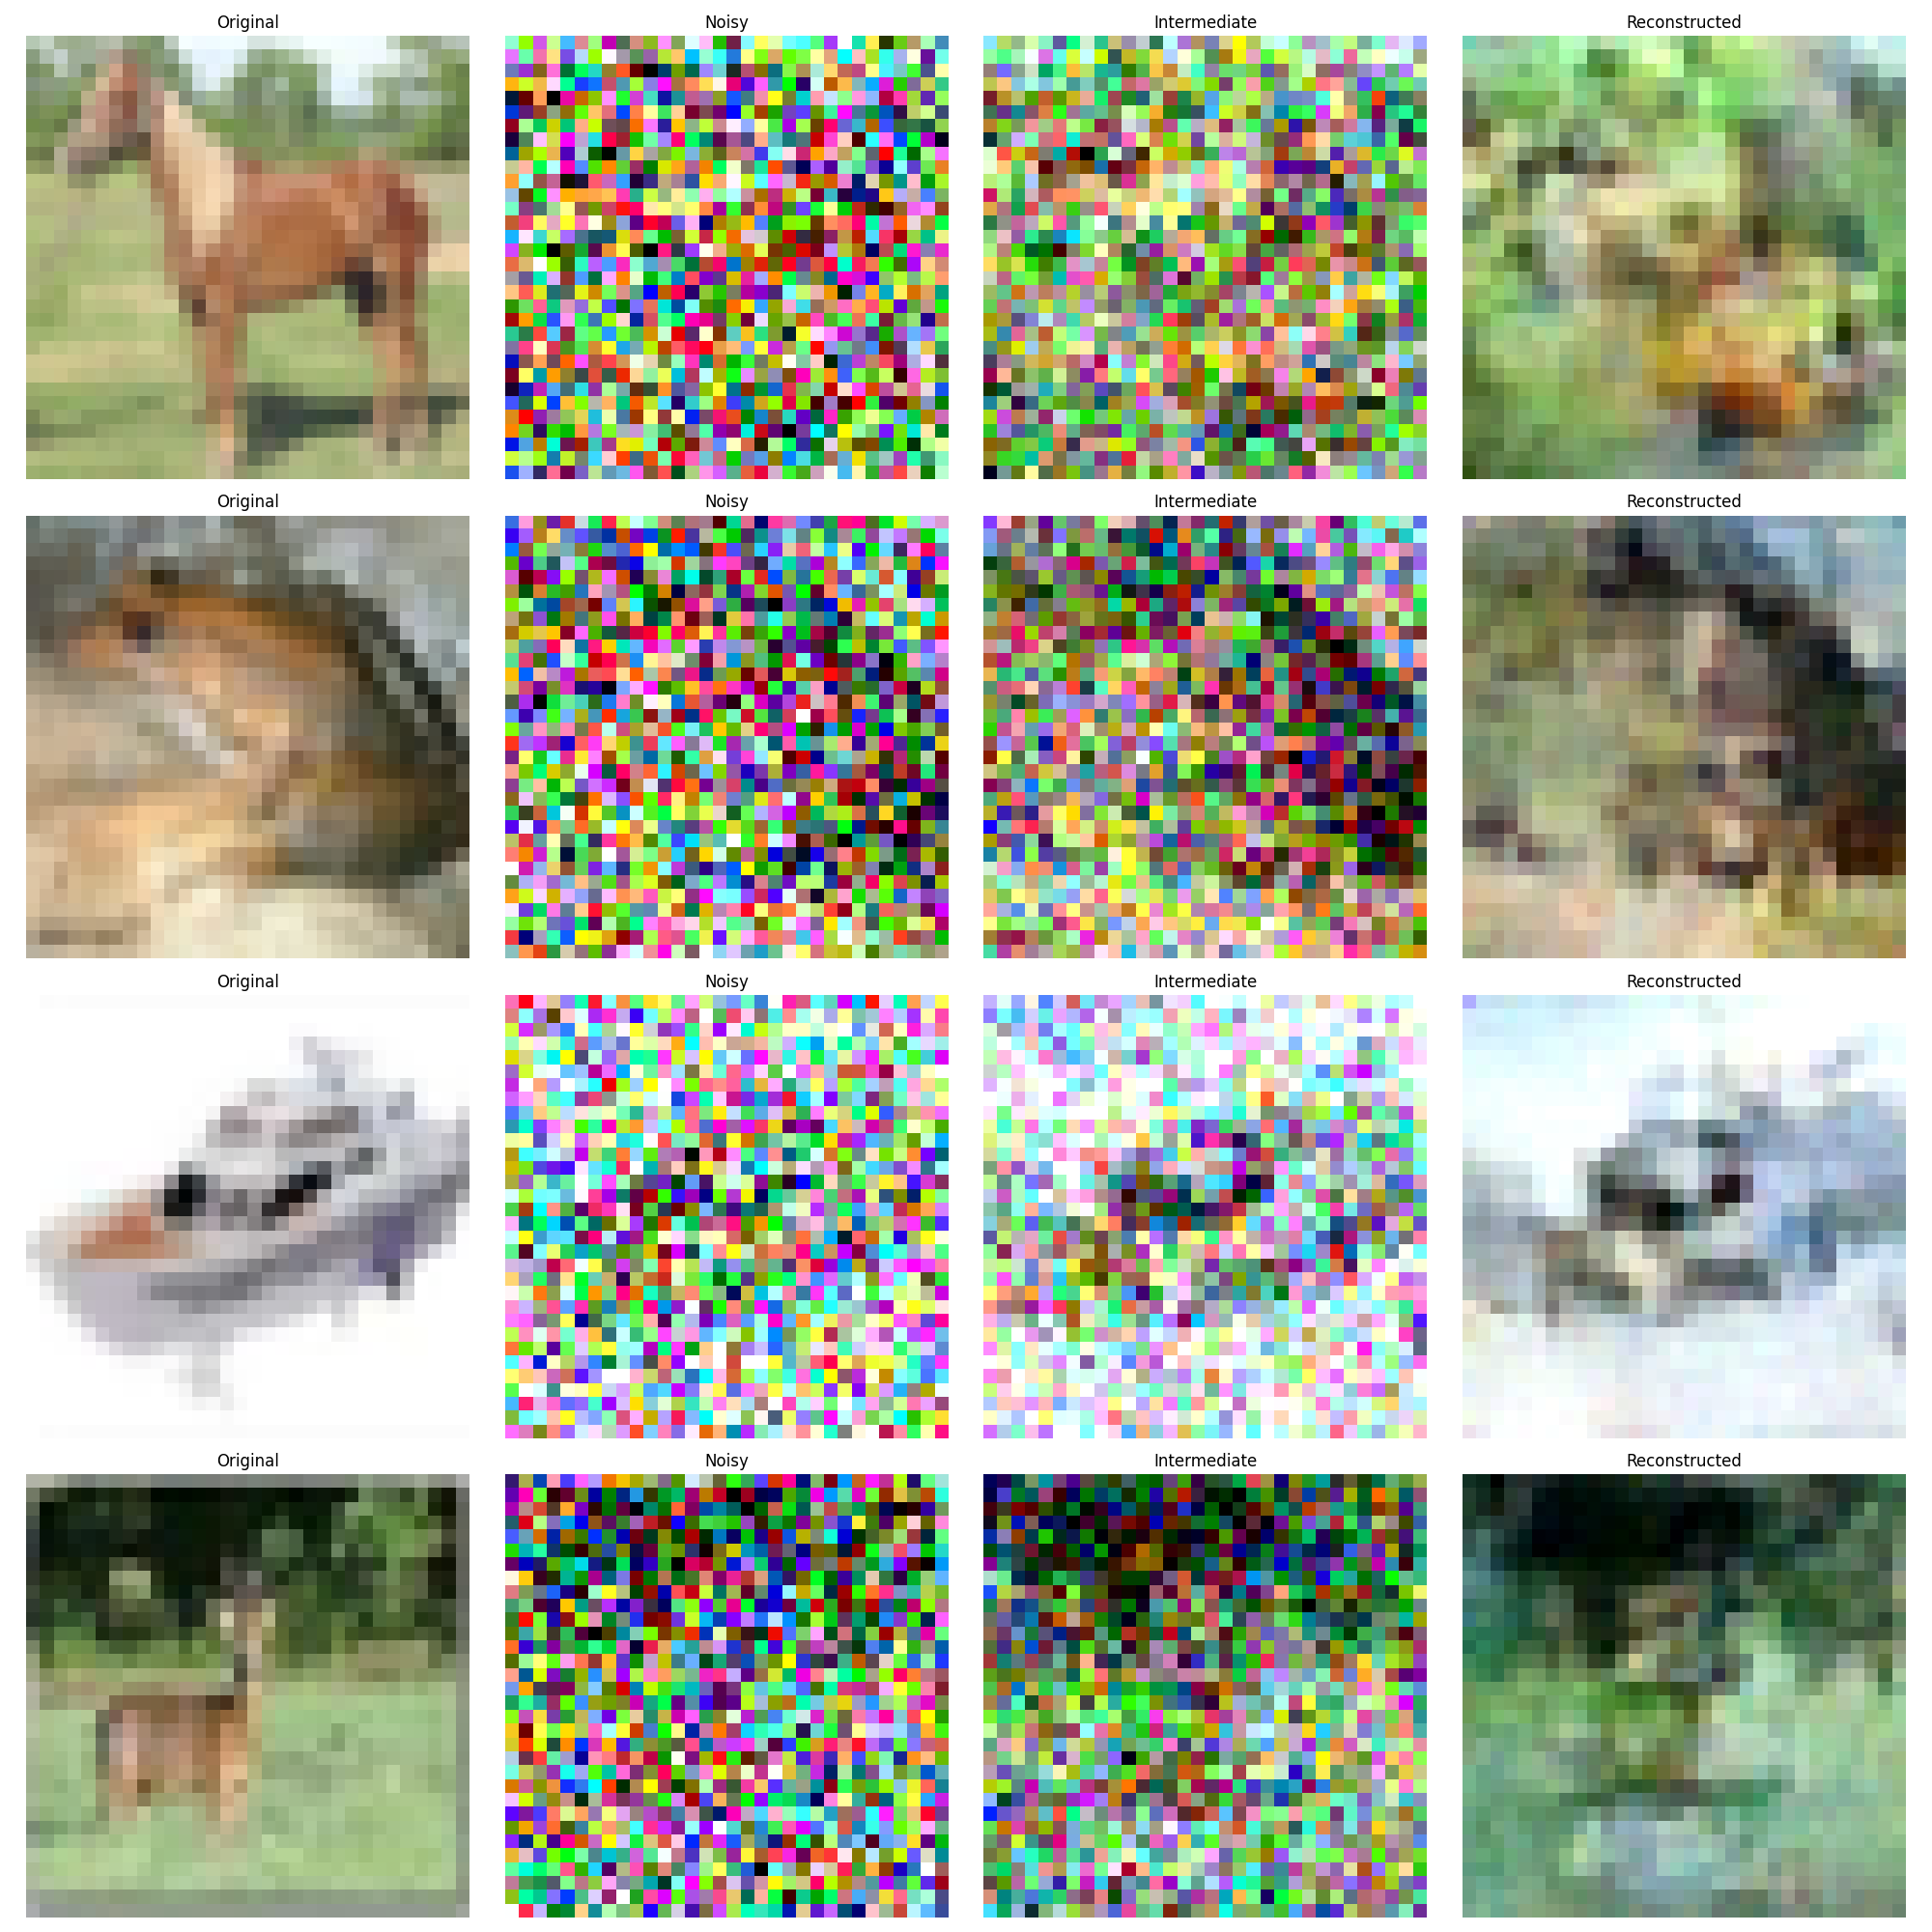

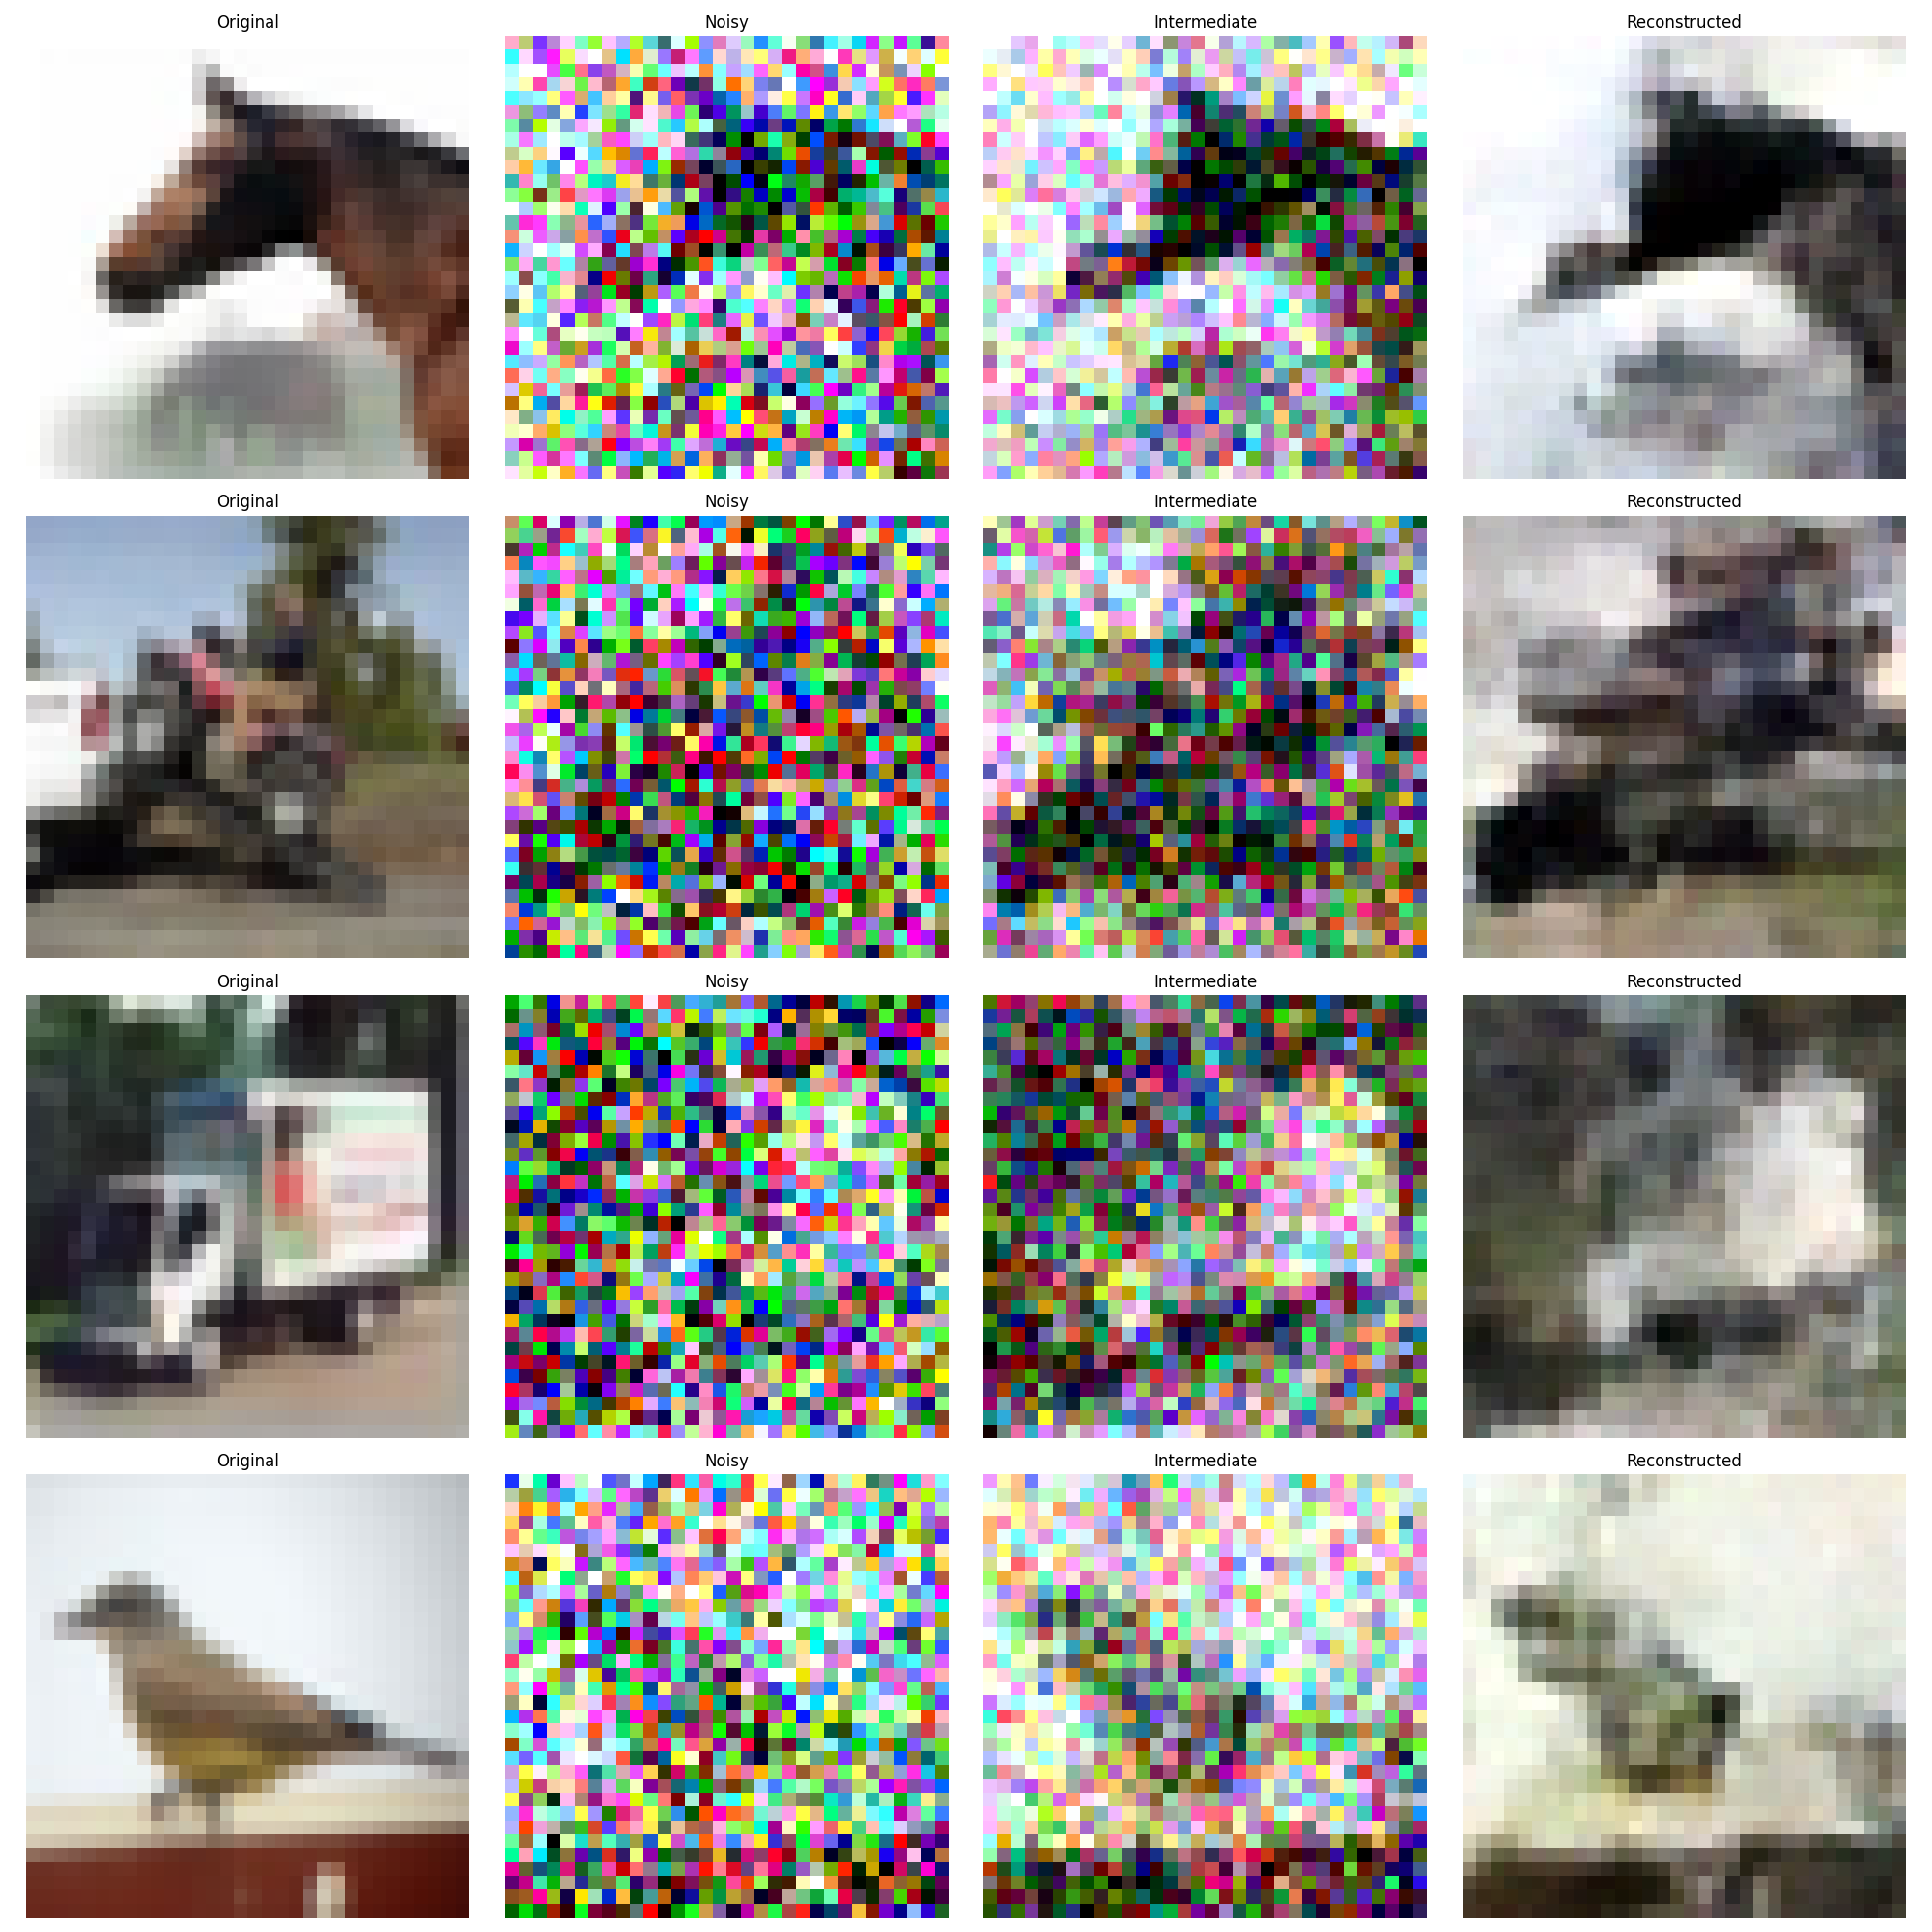

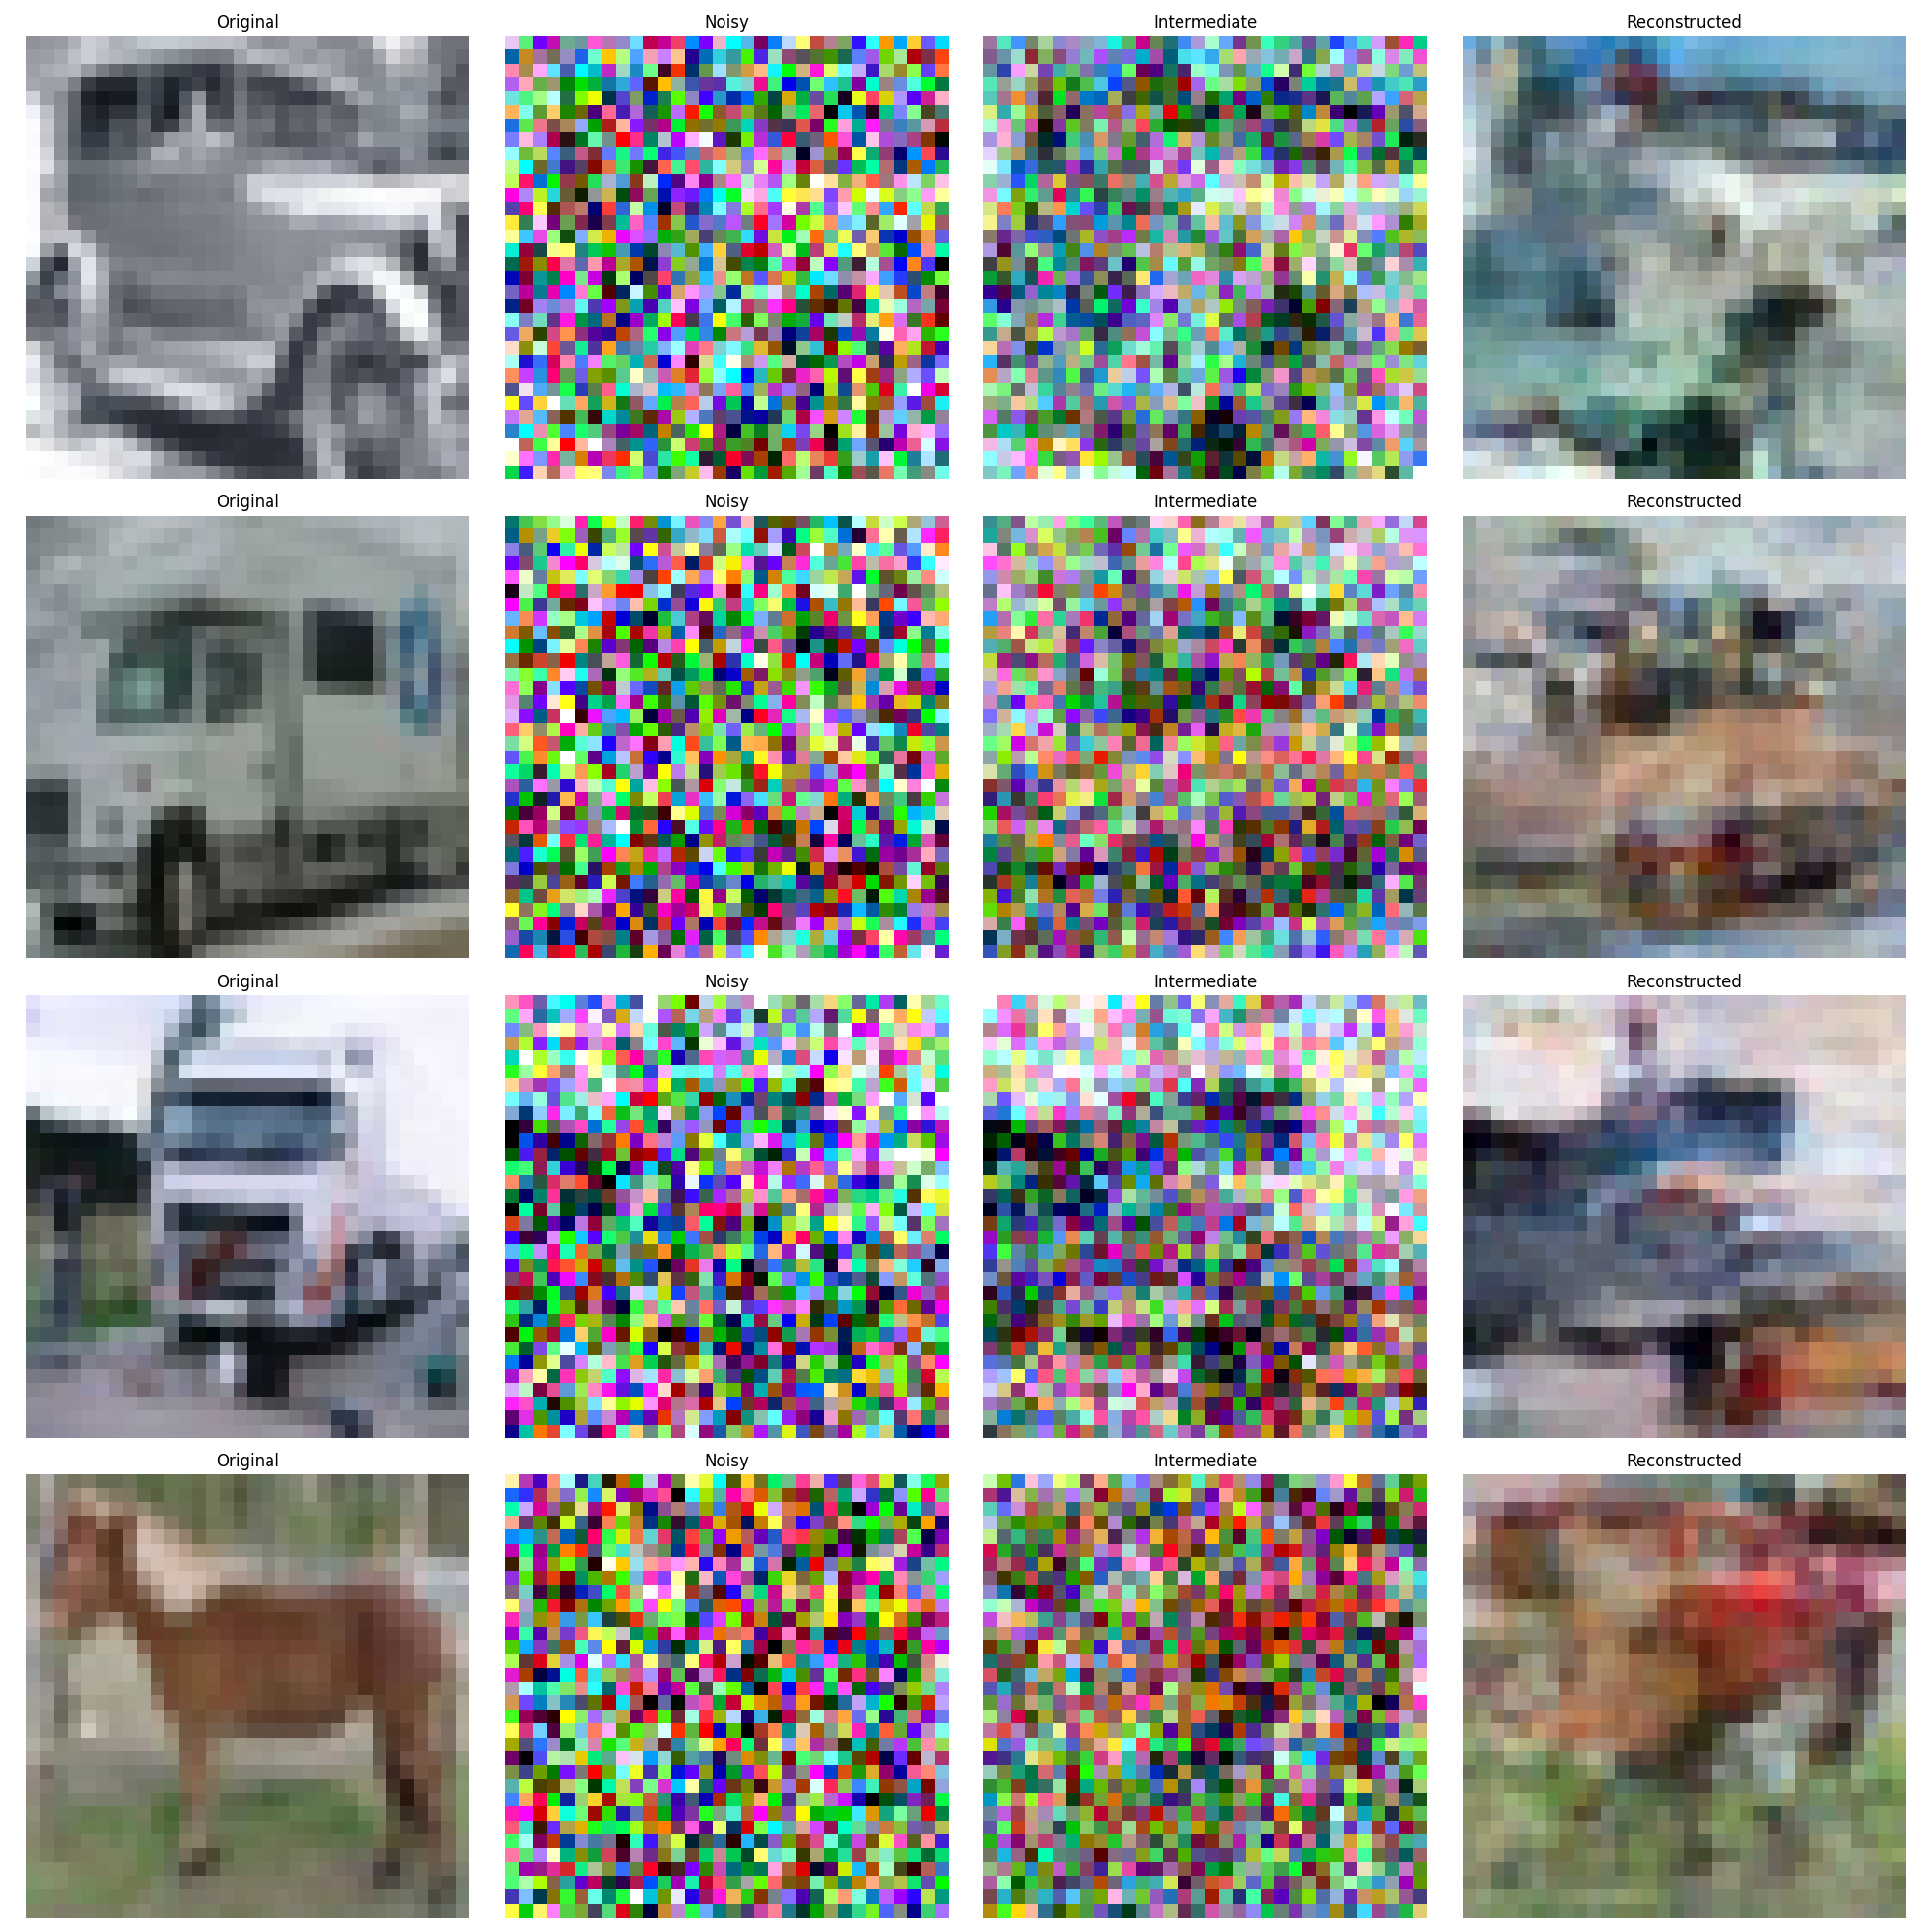

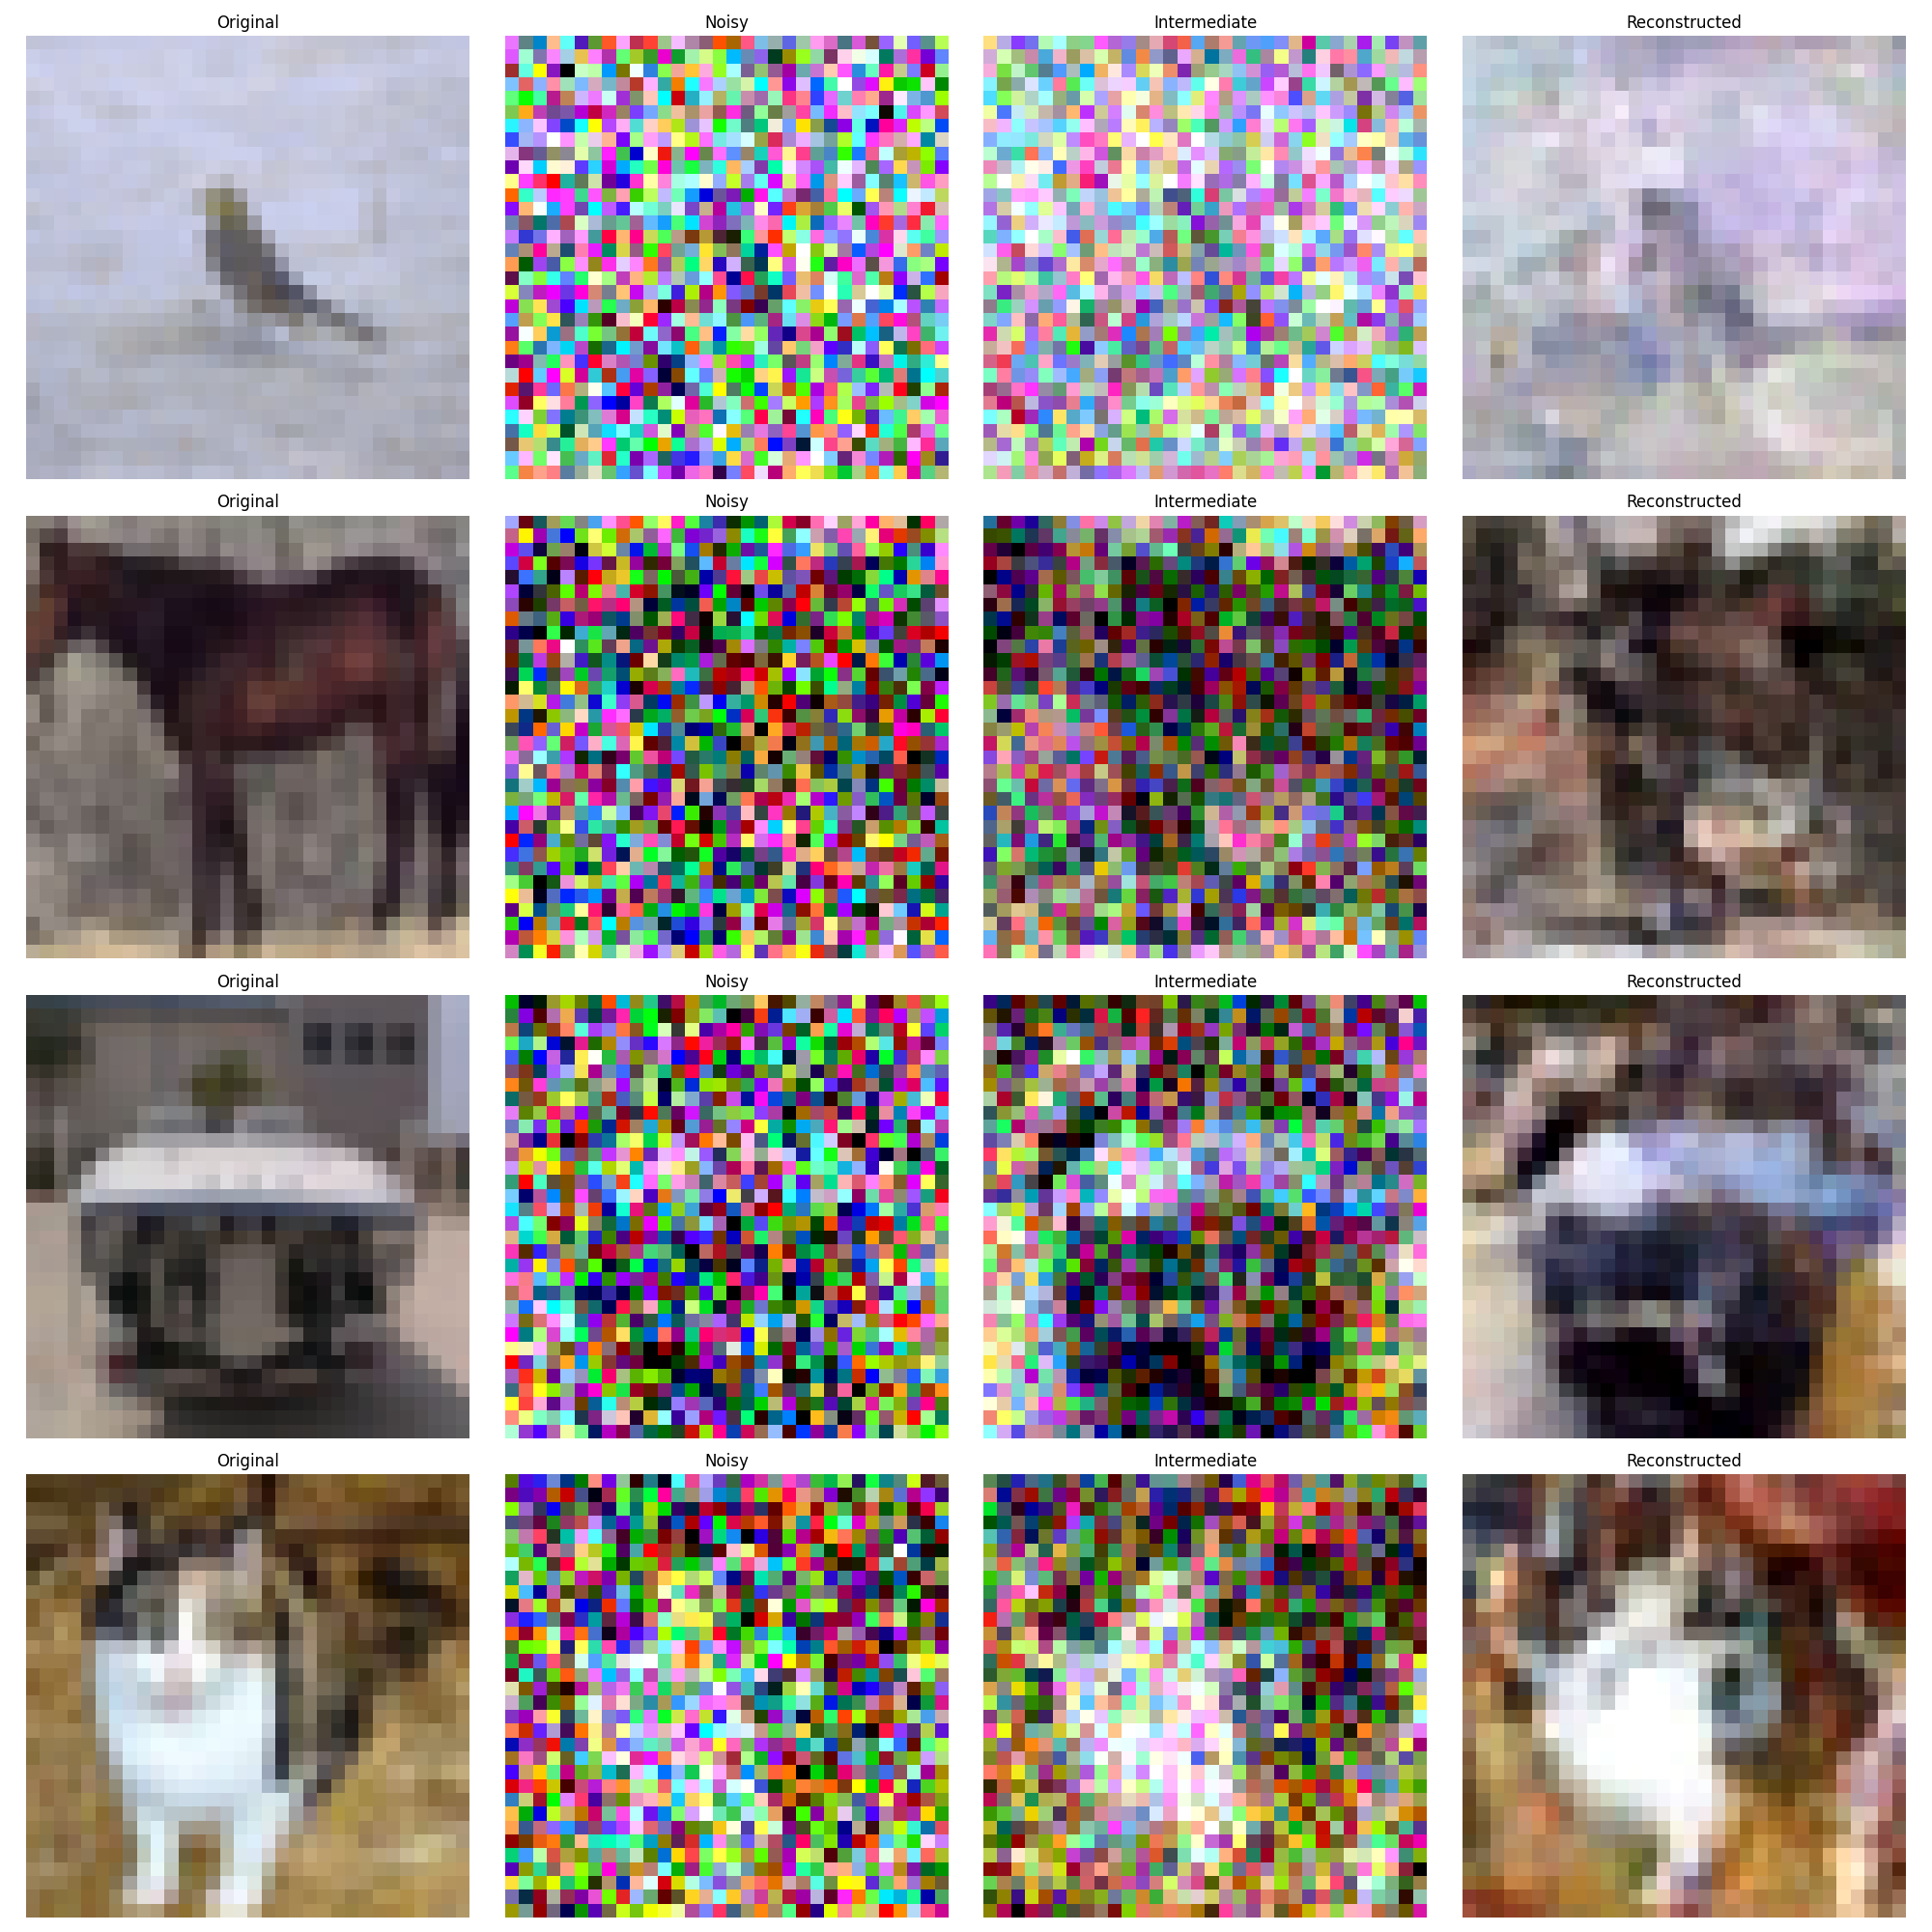

In [11]:
from IPython.display import Image, display
import glob

# Display all reconstruction images
for image_path in sorted(glob.glob('reconstruction_epoch_diffusion_*.png')):
    display(Image(filename=image_path))

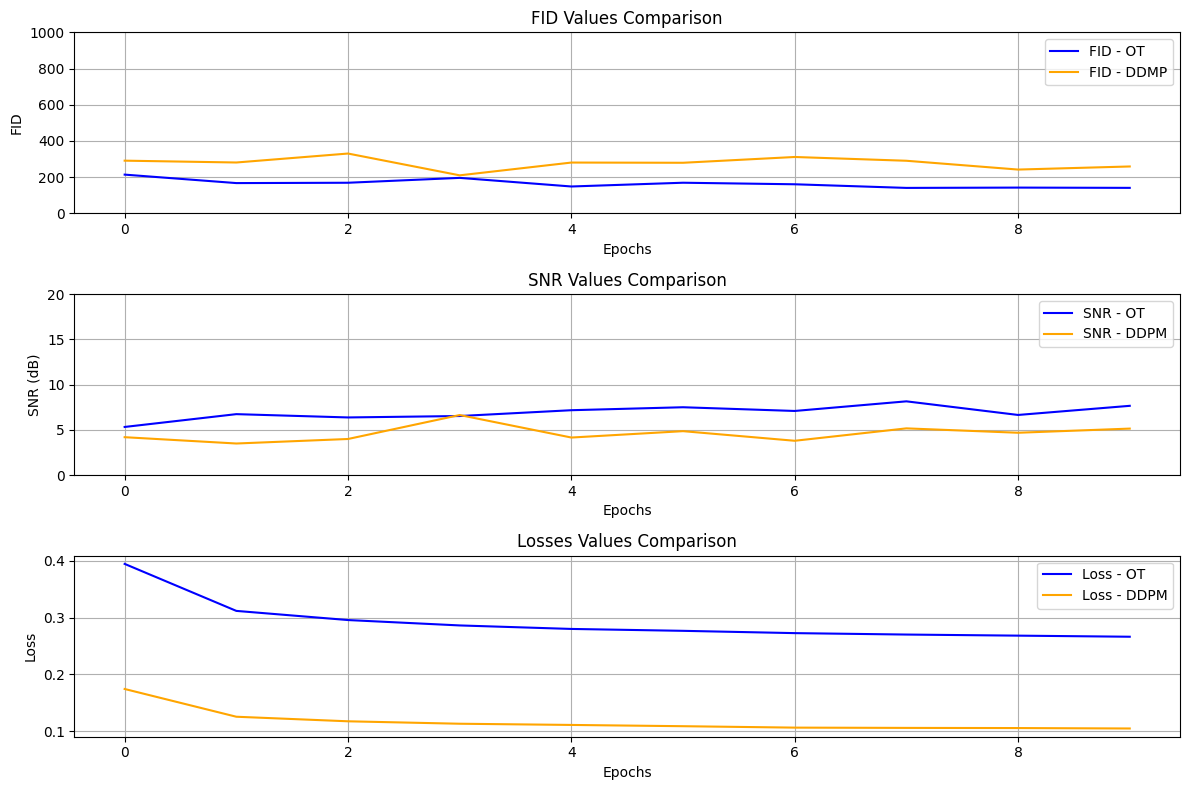

In [12]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(fid_values, label='FID - OT', color='blue')
plt.plot(fid_values_ddpm, label='FID - DDMP', color='orange')
plt.title('FID Values Comparison')
plt.xlabel('Epochs')
plt.ylabel('FID')
plt.legend()
plt.ylim(0, 1000)
plt.grid()

# Plot SNR values
plt.subplot(3, 1, 2)
plt.plot(snr_values, label='SNR - OT', color='blue')
plt.plot(snr_values_ddpm, label='SNR - DDPM', color='orange')
plt.title('SNR Values Comparison')
plt.xlabel('Epochs')
plt.ylabel('SNR (dB)')
plt.legend()
plt.ylim(0, 20)
plt.grid()

# Plot SNR values
plt.subplot(3, 1, 3)
plt.plot(total_losses, label='Loss - OT', color='blue')
plt.plot(losses_ddpm, label='Loss - DDPM', color='orange')
plt.title('Losses Values Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()